In [ ]:
!conda create --name coding-fairness python=3.9
# Activate your environment
!conda activate coding-fairness

# Install ipykernel if not already installed
!conda install ipykernel

# Add the environment to Jupyter
! python -m ipykernel install --user --name=coding-fairness --display-name="Python (coding-fairness)"

!pip install -r "C:/Users/Michalina/MasterThesis/PWR/coding-fairness/requirements.txt"0


^C
^C


Import data, save in data frame display basic statistics about missing values

In [ ]:
import pandas as pd 
filepath_dataset_demographic = r"C:\Users\Michalina\MasterThesis\PWR\coding-fairness\dataset\netsense\demsurveyMergedCodedDisID.csv"
demog_df = pd.read_csv(filepath_dataset_demographic)


# Display basic information about the dataset
print("\nBasic Information:")
print(demog_df.info())


# Calculate the percentage of missing values for each feature
missing_percentage = demog_df.isnull().mean() * 100

Drop  columns which keep name and lastname columns

In [2]:
import pandas as pd
import re

#drop columns of Name and LastName ('v{number}')
# Regex pattern to find columns to drop
pattern = r'^v\d+$'
columns_to_drop = [col for col in demog_df.columns if re.match(pattern, col)]
demog_df.drop(columns=columns_to_drop, inplace=True)

Analysis of potential features based on their names - dividing rows into multiple entries

In [3]:
"""
We need to divide one row into multiple entries,potentially 6 of them, because it is a value of how many surveys has been made by a given student. For a given entry we need to leave only the columns which have _X in a name where X is FORM RANGE 1 2 3 4 5 6. S I want one entry to habe all features with the same _X value fo rinstance _1 pluys all the features which does not have '_X' in the name.   (Cause we have for instance musicpref1_6, musicpref1_5, musicpref1_4, musicpref1_ etc andwe want to have a column musicpref1 and six records where the values for this columns are taken from musicpref1_6, musicpref1_5, musicpref1_4, musicpref1_... the X is the value of SurveyNr (1, 2, 3, 4, 5, 6)
"""
import re
pattern = r'_[1-6]$'

# List variable columns based on the pattern
variable_columns = [col for col in demog_df.columns if re.search(pattern, col)]
constant_columns = [col for col in demog_df.columns if not re.search(pattern, col)]


Correction of column names

In [15]:
def adjust_column_names(col_name):
    new_col_name = re.sub(r'_(?!\d+$)', '', col_name)
    return new_col_name

# Apply the function to each column name and rename them
demog_df.rename(columns={col: adjust_column_names(col) for col in demog_df.columns}, inplace=True)


Dividing one entry row into 6 rows, so one row per semeter

In [16]:
import pandas as pd
import re

def get_stubnames(columns):
    stub_set = set()
    pattern = re.compile(r'(.*)_\d+$')
    for col in columns:
        match = pattern.match(col)
        if match:
            stub_set.add(match.group(1))
    return list(stub_set)

# Assuming 'demog_df' and 'variable_columns' are defined somewhere above this code
stubnames = get_stubnames(variable_columns)

# Drop duplicates for each survey-specific column combined with 'egoid'
for stub in stubnames:
    for num in range(1, 7):  # Assuming survey numbers range from 1 to 6
        col_name = f"{stub}_{num}"
        if col_name in demog_df.columns:
            demog_df.drop_duplicates(subset=['egoid', col_name], inplace=True)

# Make sure 'egoid' is set as the index
if 'egoid' not in demog_df.index.names:
    demog_df.set_index('egoid', inplace=True)

# Convert DataFrame from wide to long format
try:
    # Ensure index is properly reset before conversion if it's already set
    demog_df.reset_index(inplace=True)
    demog_df = pd.wide_to_long(demog_df, 
                               stubnames=stubnames, 
                               i='egoid', 
                               j='SurveyNr', 
                               sep='_', 
                               suffix=r'\d+').reset_index()
    # Reset the index to flatten the DataFrame after transformation
    demog_df.reset_index(drop=True, inplace=True)
except Exception as e:



Transformed DataFrame:    egoid  SurveyNr  duplicate          merge_1 merge_2 merge_4 merge_5  \
0  97900         6        NaN  master only (1)     NaN     NaN     NaN   
1  92782         6        NaN  master only (1)     NaN     NaN     NaN   
2  96362         6        NaN  master only (1)     NaN     NaN     NaN   
3  90281         6        NaN  master only (1)     NaN     NaN     NaN   
4  91257         6        NaN  master only (1)     NaN     NaN     NaN   

  merge_6  sender musicpref6  ...  homosexual  typebookread5 iamsomeonewho40  \
0     NaN     NaN        NaN  ...         NaN            NaN             NaN   
1     NaN     NaN        NaN  ...         NaN            NaN             NaN   
2     NaN     NaN        NaN  ...         NaN            NaN             NaN   
3     NaN     NaN        NaN  ...         NaN            NaN             NaN   
4     NaN     NaN        NaN  ...         NaN            NaN             NaN   

  usesocnetwork8 iamsomeonewho36 clubsclu33 guessch

Remove duplicates if exisits

In [19]:
import pandas as pd

def remove_duplicate_columns(df):
    new_columns = {}
    for col in df.columns:
        if col not in new_columns:
            column_data = df[col]
            if isinstance(column_data, pd.DataFrame):
                column_data = column_data.iloc[:, 0]
            new_columns[col] = column_data.squeeze() 
    return pd.DataFrame(new_columns)


try:
    demog_df = remove_duplicate_columns(demog_df)
except Exception as e:
    print("Error:", e)


In [20]:
# Sort by SurveyNr and reset index for clarity
demog_df.sort_values(by=['SurveyNr'], inplace=True)
demog_df.reset_index(drop=True, inplace=True)


Now I want to cluster the column names in order to get the aggregation of the features which can be used to encode different features. SO for intance we can made some aggregation operation based on the all values under those similar columns (similar columns because we gathered data for a given person's closest network)

- To do that I want to perform hierarchical clustering, which does not require specyfing numer of clusters/groups as the input parameter.  

Hierarchical clustering:  
1. Calculate the pairwise distances between the column names based on a suitable distance metric (like Levenshtein distance).
2. Use hierarchical clustering to organize these column names into a dendrogram.
3. Cut the dendrogram at a chosen height to determine the clusters.

Operations on string values to get rid of typos etc. so we map the same vlaues but in a different case for instance

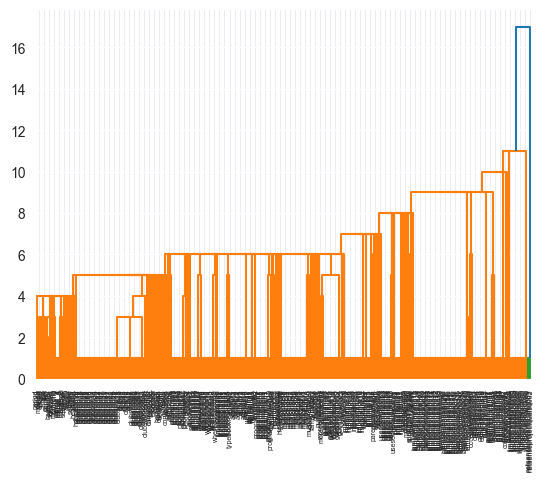

     Cluster ID Column Common Substring  \
0            58                   egoid   
1            81                SurveyNr   
2            44               duplicate   
3            54                   merge   
4            56                       e   
..          ...                     ...   
108          80                abortion   
109         111           agreeableness   
110          51          clubsothercode   
111          98              homosexual   
112          36       typebookreadother   

                                               Columns  \
0                                              [egoid]   
1                                           [SurveyNr]   
2                                          [duplicate]   
3    [merge_1, merge_2, merge_4, merge_5, merge_6, ...   
4         [sender, hsgrade, hsgender, gender, sendsms]   
..                                                 ...   
108                                         [abortion]   
109                

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from Levenshtein import distance 
import matplotlib.pyplot as plt
import numpy as np


column_names = demog_df.columns.tolist()
dist_array = []
n = len(column_names)
for i in range(n):
    for j in range(i + 1, n):
        dist_array.append(distance(column_names[i], column_names[j]))

dist_matrix = np.array(dist_array)
linked = linkage(dist_matrix, 'single')

# Dendrogram visualization
dendrogram(linked, labels=column_names, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

# Clustering based on a set distance
max_distance = 3  # This distance threshold is a key parameter
clusters = fcluster(linked, max_distance, criterion='distance')

# Group column names by their clusters
clustered_columns = {}
for label, cluster_id in zip(column_names, clusters):
    if cluster_id not in clustered_columns:
        clustered_columns[cluster_id] = []
    clustered_columns[cluster_id].append(label)

# Helper function for common substring
def longest_common_substring(lst):
    if not lst:
        return ""
    shortest = min(lst, key=len)
    for length in range(len(shortest), 0, -1):
        for start in range(len(shortest) - length + 1):
            substring = shortest[start:start + length]
            if all(substring in item for item in lst):
                return substring
    return ""

# Collecting data for DataFrame
cluster_data = []
for cluster_id, cols in clustered_columns.items():
    common_substr = longest_common_substring(cols)
    unique_values = {col: demog_df[col].unique().tolist() for col in cols}
    cluster_data.append({
        "Cluster ID": cluster_id,
        "Column Common Substring": common_substr,
        "Columns": cols,
        "Data Types": [demog_df[col].dtype for col in cols],
        "Possible Values": unique_values
    })

# Create DataFrame from list of dictionaries
clustered_cols_df = pd.DataFrame(cluster_data)

# Display the DataFrame
print(clustered_cols_df)


#Now get the features which descibe directly a user (so he is not referring to his social network, but he is talikng about himself)
direct_student_features_col_descs = clustered_cols_df[clustered_cols_df['Columns'].apply(lambda x: len(x) <= 6)]
rel_student_features_col_descs = clustered_cols_df[clustered_cols_df['Columns'].apply(lambda x: len(x) > 6)]


values_to_remove = ['lastpageseen','completed', 'duplicate']
values_to_unique_id= ['egoid', 'SurveyNr']

values_to_remove_rel = ['iamsomeonewho']

direct_student_features_col_descs = direct_student_features_col_descs[
    ~direct_student_features_col_descs['Column Common Substring'].isin(values_to_remove)]

rel_student_features_col_descs = rel_student_features_col_descs[
    ~rel_student_features_col_descs['Column Common Substring'].isin(values_to_remove_rel)]

given_student_cols = list(set(col for sublist in direct_student_features_col_descs['Columns'] for col in sublist))
rel_student_cols = list(set(col for sublist in rel_student_features_col_descs['Columns'] for col in sublist))

demog_df_one_student_ft = demog_df[given_student_cols]



if {'egoid', 'SurveyNr'}.issubset(demog_df_one_student_ft.columns):
    # Set 'egoid' and 'SurveyNr' as a MultiIndex
    demog_df_one_student_ft.set_index(['egoid', 'SurveyNr'], inplace=True)

Analyze more complexed features

In [49]:
from helpers import drop_missing_data


demog_df_rel_student_ft = demog_df[['egoid', 'SurveyNr'] + rel_student_cols]

demog_df_rel_student_ft = drop_missing_data(demog_df_rel_student_ft,  threshold=20, axis=1)

demog_df_rel_student_ft[demog_df_rel_student_ft['SurveyNr'] != 1]

demog_df_rel_student_ft = drop_missing_data(demog_df_rel_student_ft,  threshold=15, axis=0)

print(demog_df_rel_student_ft.columns.values)


['egoid' 'SurveyNr' 'musicpref6' 'activity2' 'guesschance7'
 'guesschance11' 'musicpref21' 'typebookread3' 'typebookread6'
 'guesschance2' 'guesschance3' 'activity12' 'importance8' 'importance6'
 'musicpref22' 'guesschance9' 'importance16' 'activity11' 'typebookread2'
 'importance15' 'musicpref9' 'importance11' 'typebookread1'
 'typebookread8' 'musicpref19' 'importance3' 'musicpref8' 'activity9'
 'guesschance8' 'musicpref18' 'importance14' 'guesschance5' 'musicpref17'
 'musicpref16' 'musicpref3' 'musicpref1' 'activity8' 'musicpref14'
 'musicpref4' 'importance10' 'timeperweekactivea' 'guesschance12'
 'guesschance14' 'importance13' 'importance4' 'activity10' 'typebookread9'
 'importance12' 'importance2' 'musicpref2' 'musicpref10' 'importance5'
 'guesschance4' 'activity4' 'timeperweekactiveb' 'activity6'
 'typebookread4' 'activity3' 'typebookread7' 'musicpref5' 'importance1'
 'importance7' 'activity5' 'musicpref20' 'guesschance10' 'musicpref12'
 'activity7' 'activity13' 'activity14' 'musi

In [50]:
# Assuming demog_df_one_student_ft is already defined and contains your data
groups = {}
col_groups = ["activity", "guesschance", "importance", "musicpref", "timeperweekactive", "typebookread"]

for group in col_groups:
    # Filter columns containing the group name
    columns_to_retrieve = [col for col in demog_df_rel_student_ft.columns if group in col]

    # Concatenate the data from these columns into one Series
    all_data = pd.concat([demog_df_rel_student_ft[col] for col in columns_to_retrieve], axis=0)

    # Now get unique values from this concatenated Series
    unique_values = all_data.unique()

    # Store the unique values in the dictionary
    groups[group] = unique_values

# Print the groups dictionary to see the unique values by group
for key, value in groups.items():
    print(f"{key}: {value}")

    missing_percentage = demog_df_rel_student_ft.isnull().mean() * 100

activity: ['1-2 times a month' 'Not at all' 'Less than 1-2 times a month'
 '1-2 times a week' 'Less than 1-2 Times a month'
 'Everyday or almost everyday' '1-2 Times a week' '1-2 Times a month' nan]
guesschance: ['No chance' 'Some chance' 'Very little chance' 'Very good chance' nan
 'Have already done']
importance: ['4' 'Essential' 'Very important' 'Somewhat important' nan 'Not Important']
musicpref: ['No' 'Yes']
timeperweekactive: ['3-5 Hours' '11-15' 'Over 20 Hours' '6-10 Hours' '1-2 Hours'
 'Less than an hour' '16-20' '6-10 hours' '16-20 hours' '11-15 hours'
 'Over 20' '3-5 hours' '1-2 hours' nan '8' 'Less than half an hour']
typebookread: ['No' 'Yes']


TRANSFORMATION TO EXTRACT FEATURES FROM ACTIVITIES

In [51]:

def map_activities(df, mapping, default_value=-1):
    for column in df.columns:
        if 'activity' in column:
            # Convert to lower case before mapping and fill NaN with a default value if no match is found
            df[column] = df[column].str.lower().map(mapping).fillna(default_value)
    return df

# Reapply the mapping for activity columns if they include inconsistent string capitalization
# Adjusted mapping dictionary to be comprehensive
activity_mapping = {
    "everyday or almost everyday": 4,
    "1-2 times a week": 3,
    "1-2 times a month": 2,
    "less than 1-2 times a month": 1,
    "not at all": 0
}

demog_df_rel_student_ft = map_activities(demog_df_rel_student_ft, activity_mapping)

demog_df_rel_student_ft['abstinent'] = demog_df_rel_student_ft.apply(lambda row: 1 if row['activity3'] == 0 
                           and row['activity4'] == 0 
                           and row['activity5'] == 0 else 0, axis=1)

#Wellness score

# Assume activity6 has positive scores and activity7, activity8 have negative impacts
demog_df_rel_student_ft['Wellness_Score'] = demog_df_rel_student_ft['activity6'] - \
                                           (demog_df_rel_student_ft['activity7'] + demog_df_rel_student_ft['activity8'])
""""
activity6 == Exercised
activity7 == Felt overwhelmed by all I had to do
activity8 == Felt depressed
"""

#civic engagement  score
demog_df_rel_student_ft['Civic_Engagement_Score'] = demog_df_rel_student_ft[['activity2', 'activity12', 'activity13', 'activity14']].sum(axis=1)

"""
activity2 == Demonstrated for a
cause
activity12 == Discussed politics
activity13 == Worked on a local,
state, or national
political campaign
activity14 == Publicly communicated

"""

#cultural_interaction_score
"""
activity9 == Performed volunteer work
activity10 == Socialized with
someone of another
racial/ethnic group
"""

demog_df_rel_student_ft['Cultural_Interaction_Score'] = demog_df_rel_student_ft[['activity9', 'activity10']].sum(axis=1)


#religious ansspiritual engagement
"""
activity1 == religous_attendance
activity11 == Discussed religion
"""
demog_df_rel_student_ft['Religious_Engagement_Score'] = demog_df_rel_student_ft[['activity1', 'activity11']].sum(axis=1)

from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# List of columns to normalize
columns_to_normalize = ['Wellness_Score', 'Civic_Engagement_Score', 'Cultural_Interaction_Score', 'Religious_Engagement_Score']

# Apply Min-Max scaling to the specified columns
for column in columns_to_normalize:
    # Reshape data using .values.reshape(-1, 1) because scaler expects 2D array
    demog_df_rel_student_ft[column] = scaler.fit_transform(demog_df_rel_student_ft[[column]])


# Dictionary to map old column names to new, more descriptive names
column_name_mapping = {
    'activity1': 'Religious_Attendance',
    'activity2': 'Demonstrated_For_Cause',
    'activity3': 'Smoked_Cigarette',
    'activity4': 'Drank_Beer',
    'activity5': 'Drank_Wine_or_Liquor',
    'activity6': 'Exercised',
    'activity7': 'Felt_Overwhelmed',
    'activity8': 'Felt_Depressed',
    'activity9': 'Performed_Volunteer_Work',
    'activity10': 'Socialized_Diverse_Groups',
    'activity11': 'Discussed_Religion',
    'activity12': 'Discussed_Politics',
    'activity13': 'Political_Campaign_Work',
    'activity14': 'Public_Communication'
}

# Use the rename method to change column names
demog_df_rel_student_ft.rename(columns=column_name_mapping, inplace=True)



Making features from 'guesschance' columns

In [4]:
###################################################################################

def map_act(df, mapping, default_value=-1):
    for column in df.columns:
        if 'guesschance' in column:
            # Convert to lower case before mapping and fill NaN with a default value if no match is found
            df[column] = df[column].str.lower().map(mapping).fillna(default_value)
    return df

guesschance_mapping = {
    'have already done': 5,
    'very good chance': 4,
    'some chance': 3,
    'very little chance': 2,
    'no chance': 1,
    'nan': 0  # If there are string 'nan' or handle np.nan differently if needed
}

# Apply the mapping function to your DataFrame
demog_df_rel_student_ft = map_act(demog_df_rel_student_ft, guesschance_mapping)

# Mapping from column names to subgroup categories
column_to_subgroup = {
    'guesschance1': 'Future_Academic_Changes',  # Change major field
    'guesschance2': 'Future_Career_Changes',  # Change career choice
    'guesschance3': 'Likelihood_Student_Gov_Participation',  # Participate in student government
    'guesschance4': 'Probability_Job_For_Education',  # Have a job to help pay for college expenses
    'guesschance5': 'Likelihood_Sports_Participation',  # Play club, intramural or recreational sports
    'guesschance6': 'Likelihood_Intercollegiate_Athletics',  # Play intercollegiate athletics
    'guesschance7': 'Probability_Student_Protests',  # Participate in student protests or demonstrations
    'guesschance8': 'Potential_College_Transfer',  # Transfer to another college before graduating
    'guesschance9': 'Engagement_Volunteer_Work',  # Participate in volunteer or community service work
    'guesschance10': 'Socialization_Across_Cultures',  # Socialize with someone of another racial/ethnic group
    'guesschance11': 'Seeking_Personal_Counseling',  # Seek personal counseling
    'guesschance12': 'Feeling_Overwhelmed_Often',  # Felt overwhelmed by all I had to do
    'guesschance13': 'Experiences_of_Depression',  # Felt depressed
    'guesschance14': 'Active_Community_Volunteerism',  # Performed volunteer work
}


# Create a DataFrame to hold scores for each subgroup
subgroup_scores = {subgroup: [] for subgroup in set(column_to_subgroup.values())}

# Aggregate scores by subgroup
for column, subgroup in column_to_subgroup.items():
    subgroup_scores[subgroup].append(demog_df_rel_student_ft[column])

# Compute average scores for each subgroup
for subgroup, scores in subgroup_scores.items():
    demog_df_rel_student_ft[subgroup + '_Score'] = pd.concat(scores, axis=1).mean(axis=1)


###NORMALIZE  THE SCORE VALUES
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Define a list of the new score columns that need normalization
# Assuming these are the only ones ending with '_Score' that were recently added and not normalized yet
new_score_columns = [subgroup + '_Score' for subgroup in set(column_to_subgroup.values())]

# Apply Min-Max scaling to the specified new score columns
for column in new_score_columns:
    # Check if the column is in the DataFrame to avoid KeyError
    if column in demog_df_rel_student_ft.columns:
        demog_df_rel_student_ft[column] = scaler.fit_transform(demog_df_rel_student_ft[[column]])


demog_df_rel_student_ft_copy = demog_df_rel_student_ft.copy()
columns_to_del_guesschance  =  [col for col in demog_df_rel_student_ft.columns if 'guesschance' in col]
demog_df_rel_student_ft.drop(columns=columns_to_del_guesschance, inplace=True)

NameError: name 'demog_df_rel_student_ft' is not defined

Importance features  development

In [54]:

"""
Please indicate the importance to you personally of each of the following?
"""
# Define the mapping function
def map_importance(df, mapping, default_value=-1):
    for column in df.columns:
        if 'importance' in column:
            # Convert to lower case before mapping and fill NaN with a default value if no match is found
            df[column] = df[column].str.lower().map(mapping).fillna(default_value)
    return df

# Mapping from responses to scores
response_to_score = {
    'essential': 4,
    'very important': 3,
    'somewhat important': 2,
    'not important': 1
}

# Apply the mapping function to your DataFrame
demog_df_rel_student_ft = map_importance(demog_df_rel_student_ft, response_to_score)


# Now perform the grouping and scoring
group_definitions = {
    'Artistic Achievement': ['importance1'],
    'Professional Development': ['importance2', 'importance3'],
    'Political and Social Influence': ['importance4', 'importance5'],
    'Family and Personal Life': ['importance6', 'importance7'],
    'Community and Environmental Engagement': ['importance8', 'importance14', 'importance16'],
    'Scientific and Creative Contribution': ['importance9', 'importance10', 'importance11'],
    'Leadership and Awareness': ['importance12', 'importance13', 'importance15']
}

for group, cols_importance in group_definitions.items():
    demog_df_rel_student_ft[group + '_Score'] = demog_df_rel_student_ft[cols_importance].mean(axis=1)

scaler = MinMaxScaler()

# Assuming 'group_definitions' from previous steps have been used to create these score columns
score_columns = [group + '_Score' for group in group_definitions.keys()]

# Normalize these scores
for col in score_columns:
    demog_df_rel_student_ft[col] = scaler.fit_transform(demog_df_rel_student_ft[[col]])

demog_df_rel_student_ft_copy = demog_df_rel_student_ft.copy()
columns_to_del_importance = [col for col in demog_df_rel_student_ft.columns if 'importance' in col]
demog_df_rel_student_ft.drop(columns=columns_to_del_importance, inplace=True)

EXTRACTING MUSIC FEATURES 

In [55]:
##########################################MUSIC PREF##################################################
# Group definitions (adjust according to the actual mapping)

def map_music_pref(df, mapping, default_value=-1):
    for column in df.columns:
        if 'musicpref' in column:
            # Convert to lower case before mapping and fill NaN with a default value if no match is found
            df[column] = df[column].str.lower().map(mapping).fillna(default_value)
    return df

music_pref_mapping = {
    'yes': 1,
    'no': 0,
    'nan': -1
}

# Apply the mapping function to your DataFrame
demog_df_rel_student_ft = map_music_pref(demog_df_rel_student_ft, music_pref_mapping)


music_groups = {
    'Classical_Traditional': ['musicpref6', 'musicpref7', 'musicpref9', 'musicpref19', 'musicpref12'],
    'Modern_Popular': ['musicpref10', 'musicpref11', 'musicpref15', 'musicpref16', 'musicpref22'],
    'Folk_Cultural': ['musicpref13', 'musicpref14', 'musicpref18'],
    'Nostalgic_Easy': ['musicpref1', 'musicpref2', 'musicpref3', 'musicpref8', 'musicpref20', 'musicpref21'],
    'Musical_Theater': ['musicpref4', 'musicpref19']
}

# Create aggregated features: Count of preferred genres per group
for group_name, columns in music_groups.items():
    demog_df_rel_student_ft[group_name + '_Score'] = demog_df_rel_student_ft[columns].sum(axis=1)


demog_df_rel_student_ft['Music_Diversity_Score'] = demog_df_rel_student_ft[[group_name + '_Score' for group_name in music_groups]].gt(0).sum(axis=1)

# Create binary indicators: Has at least one genre in each group
for group_name in music_groups:
    demog_df_rel_student_ft[group_name + '_Preferred'] = (demog_df_rel_student_ft[group_name + '_Score'] > 0).astype(int)
    
    
scaler = MinMaxScaler()

# List of columns to normalize
score_columns = [group_name + '_Score' for group_name in music_groups] + ['Music_Diversity_Score']

# Apply Min-Max scaling to the specified columns
for col in score_columns:
    # Reshape data using .values.reshape(-1, 1) because scaler expects 2D array
    demog_df_rel_student_ft[col] = scaler.fit_transform(demog_df_rel_student_ft[[col]])


demog_df_rel_student_ft_copy = demog_df_rel_student_ft.copy()
columns_to_del_music_pref  =  [col for col in demog_df_rel_student_ft.columns if 'musicpref' in col]

demog_df_rel_student_ft.drop(columns=columns_to_del_music_pref, inplace=True)


C:\Users\Michalina\AppData\Local\Temp\ipykernel_23388\1797991674.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  demog_df_rel_student_ft[group_name + '_Score'] = demog_df_rel_student_ft[columns].sum(axis=1)
C:\Users\Michalina\AppData\Local\Temp\ipykernel_23388\1797991674.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  demog_df_rel_student_ft[group_name + '_Score'] = demog_df_rel_student_ft[columns].sum(axis=1)
C:\Users\Michalina\AppData\Local\Temp\ipykernel_23388\1797991674.py:30: PerformanceWarning: DataFrame is highl

KeyError: "None of [Index(['Classical_Traditional', 'Modern_Popular', 'Folk_Cultural',\n       'Nostalgic_Easy', 'Musical_Theater'],\n      dtype='object')] are in the [columns]"

In [59]:
def map_book_pref(df, mapping, default_value=-1):
    for column in df.columns:
        if 'typebookread' in column:
            # Convert to lower case before mapping and fill NaN with a default value if no match is found
            df[column] = df[column].str.lower().map(mapping).fillna(default_value)
    return df

book_pref_mapping = {
    'yes': 1,
    'no': 0,
    'nan': -1
}

# Apply the mapping function to your DataFrame
demog_df_rel_student_ft = map_book_pref(demog_df_rel_student_ft, book_pref_mapping)



# Group definitions
book_groups = {
    'Fiction': ['typebookread1', 'typebookread2', 'typebookread3', 'typebookread4', 'typebookread5'],
    'NonFiction': ['typebookread8', 'typebookread9'],
    'SelfHelp_Informational': ['typebookread6', 'typebookread7']
}


# Create aggregated features: Count of preferred genres per group
for group_name, columns in book_groups.items():
    demog_df_rel_student_ft[group_name + '_Score'] = demog_df_rel_student_ft[columns].sum(axis=1)

# Create a feature: Diversity of reading preferences (how many groups a student reads from)
demog_df_rel_student_ft['Reading_Diversity_Score'] = demog_df_rel_student_ft[[group_name + '_Score' for group_name in book_groups]].gt(0).sum(axis=1)

# Create binary indicators: Has at least one genre in each group
for group_name in book_groups:
    demog_df_rel_student_ft[group_name + '_Preferred'] = (demog_df_rel_student_ft[group_name + '_Score'] > 0).astype(int)


scaler = MinMaxScaler()

# List of columns to normalize
score_columns = [group_name + '_Score' for group_name in book_groups] + ['Reading_Diversity_Score']

# Apply Min-Max scaling to the specified columns
for col in score_columns:
    # Reshape data using .values.reshape(-1, 1) because scaler expects 2D array
    demog_df_rel_student_ft[col] = scaler.fit_transform(demog_df_rel_student_ft[[col]])


demog_df_rel_student_ft_copy = demog_df_rel_student_ft.copy()
columns_to_del_book_pref  =  [col for col in demog_df_rel_student_ft.columns if 'typebookread' in col]
demog_df_rel_student_ft.drop(columns=columns_to_del_book_pref, inplace=True)
#

TIME  PER WEEK  EXTRACTING FEATURES 

timeperweekactive: ['3-5 Hours' '11-15' 'Over 20 Hours' '6-10 Hours' '1-2 Hours'
 'Less than an hour' '16-20' '6-10 hours' '16-20 hours' '11-15 hours'
 'Over 20' '3-5 hours' '1-2 hours' nan '8' 'Less than half an hour']

In [64]:
timeperweekactive_cols = ['timeperweekactivea', 'timeperweekactiveb']


def map_timeperweekactive(df, mapping, default_value=-1):
    for column in df.columns:
        if 'timeperweekactive' in column:
            # Convert to lower case before mapping and fill NaN with a default value if no match is found
            df[column] = df[column].str.lower().map(mapping).fillna(default_value)
    return df

#TODO: ZLE ZMAPOWANE--->PUSC JESZCZE RAZ  
time_mapping = {
    'less than half an hour': 1,
    'less than an hour': 2,
    '1-2 hours': 3,
    '3-5 hours': 4,
    '6-10 hours': 5,
    '11-15 hours': 6,
    '16-20 hours': 7,
    'over 20 hours': 8,
    'nan': 0,  # Assuming you want to handle NaNs as 0; adjust as necessary
}

# Apply the mapping function to your DataFrame
demog_df_rel_student_ft = map_timeperweekactive(demog_df_rel_student_ft, time_mapping)



scaler = MinMaxScaler()

# Apply Min-Max scaling to the specified columns
for col in timeperweekactive_cols:
    # Reshape data using .values.reshape(-1, 1) because scaler expects 2D array
    demog_df_rel_student_ft[col] = scaler.fit_transform(demog_df_rel_student_ft[[col]])

In [68]:
dir_path = r'C:\Users\Michalina\MasterThesis\PWR\coding-fairness\Demographic_Features'


demog_df_rel_student_ft.to_csv(dir_path  + 'Student_Rel_Features.csv', index=False)

Drop columns where there is more than 20 percent of missing Data

In [13]:
import numpy as np

# Assuming age is a numpy array as from demog_df['age'].values
age = demog_df['age'].values

# Counting nulls: np.isnan() works with numeric data; it does not work with None values.
null_count = np.isnan(age).sum()  # Ensure that 'age' contains NaNs, not Nones for this to work.

# Calculating the percentage of missing values
null_percentage = null_count / len(age)

# Printing missing values information
print("Missing values: {:.2%}".format(null_percentage))  # Formats as percentage

# Getting unique values and converting to set
unique_values = np.unique(age[~np.isnan(age)])  # This excludes NaN values from the unique values calculation

# Printing unique values
print("Unique values:", unique_values)


Missing values: 83.58%
Unique values: [17. 18. 19.]


In [79]:
#FILTER OUT THE COLUMNS WHERE WE HAVE LESS THAN 80%PERCENT OF DATA
missing_percentage = demog_df_one_student_ft.isnull().mean() * 100
threshold = 20
columns_to_drop = missing_percentage[
    missing_percentage >= threshold].index  # series datatype which have te columns name as the index

demog_df_one_student_ft.drop(columns=columns_to_drop, inplace=True)
demog_df_one_student_ft.reset_index(inplace=True)
demog_df_one_student_ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   egoid              1218 non-null   int64  
 1   SurveyNr           1218 non-null   int64  
 2   conscientiousness  985 non-null    float64
 3   interestitems1     982 non-null    object 
 4   interestitems6     980 non-null    object 
 5   merge_1            1200 non-null   object 
 6   marijuana          983 non-null    object 
 7   interestitems3     983 non-null    object 
 8   startlanguage      1005 non-null   object 
 9   fswelfare          984 non-null    object 
 10  wellbeing5         985 non-null    object 
 11  interestitems4     982 non-null    object 
 12  wellbeing2         985 non-null    object 
 13  agreeableness      985 non-null    float64
 14  lesseq             982 non-null    object 
 15  weight             988 non-null    float64
 16  wellbeing4         986 n

C:\Users\Michalina\AppData\Local\Temp\ipykernel_2076\3773315093.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demog_df_one_student_ft.drop(columns=columns_to_drop, inplace=True)


Feature selection process for feature directly accociated with a person answering the questions

In [80]:
demog_df_one_student_ft.drop(columns=['merge_1', 'merge_2', 'merge_4'], inplace=True)
columns_now = demog_df_one_student_ft.columns.values
print(columns_now)

['egoid' 'SurveyNr' 'conscientiousness' 'interestitems1' 'interestitems6'
 'marijuana' 'interestitems3' 'startlanguage' 'fswelfare' 'wellbeing5'
 'interestitems4' 'wellbeing2' 'agreeableness' 'lesseq' 'weight'
 'wellbeing4' 'deathpen' 'health' 'homosexual' 'interestitems2'
 'interestitems5' 'gaymarriage' 'racediscrim' 'booksread'
 'parentsmarriage' 'wellbeing3' 'wellbeing1' 'toomucheqrights'
 'neuroticism' 'happy' 'abortion' 'major' 'extraversion' 'fssocsec'
 'premaritalsex' 'eqchances' 'sender' 'occupationmom' 'political'
 'openness' 'euthanasia']


C:\Users\Michalina\AppData\Local\Temp\ipykernel_2076\763788037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demog_df_one_student_ft.drop(columns=['merge_1', 'merge_2', 'merge_4'], inplace=True)


In [81]:
#Zmien nazwy dla tych kolumn z lewe na te po drugiej stronie strzałki
#interestitems1 --> zmien nazwe na enjoy_music
#interestitems2 --> zmien nazwe na enjoy_movies
#interestitems3 --> zmien nazwe na enjoy_books
#interestitems4 --> zmien nazwe na enjoy_follow_sports
#interestitems5 --> zmien nazwe na enjoy_games
#interestitems6 --> zmien nazwe na enjoy_outdoor

# Renaming the columns as specified
rename_mapping = {
    'interestitems1': 'enjoy_music',
    'interestitems2': 'enjoy_movies',
    'interestitems3': 'enjoy_books',
    'interestitems4': 'enjoy_follow_sports',
    'interestitems5': 'enjoy_games',
    'interestitems6': 'enjoy_outdoor'
}

# Renaming the columns in the DataFrame
demog_df_one_student_ft.rename(columns=rename_mapping, inplace=True)

    



C:\Users\Michalina\AppData\Local\Temp\ipykernel_2076\2343559051.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demog_df_one_student_ft.rename(columns=rename_mapping, inplace=True)


In [83]:

columns_now = demog_df_one_student_ft.columns.values
# Find columns related to 'wellbeing' and 'interest'
cols_wellbeing = [col for col in columns_now if 'wellbeing' in col]
cols_enjoy = [col for col in columns_now if 'enjoy' in col]


# Function to replace numeric values conditionally within mixed-type columns
def replace_numeric(value, to_replace, replacement):
    # Check if the value is a digit and equals the specified number, then replace it
    if str(value).isdigit() and int(value) == to_replace:
        return replacement
    else:
        return value

# Replace '6' with 'All the time' in wellbeing-related columns
for col in cols_wellbeing:
    demog_df_one_student_ft[col] = demog_df_one_student_ft[col].apply(lambda x: replace_numeric(x, 6, 'All the time'))

# Replace '5' with 'Very much' in interest-related columns
for col in cols_enjoy:
    demog_df_one_student_ft[col] = demog_df_one_student_ft[col].apply(lambda x: replace_numeric(x, 5, 'Very much'))

# Verify changes
print(demog_df_one_student_ft)

      egoid  SurveyNr  conscientiousness enjoy_music  enjoy_outdoor  \
0     26425         1           3.333333   Very much      Very much   
1     15723         1           3.888889   Very much      Very much   
2     49597         1           4.111111   Very much      Very much   
3     65591         1           2.888889   Very much       Somewhat   
4     48187         1           3.000000   Very much  Not that much   
...     ...       ...                ...         ...            ...   
1213  36951         6                NaN         NaN            NaN   
1214  19066         6           4.111111    Somewhat       Somewhat   
1215  48429         6                NaN         NaN            NaN   
1216  64772         6                NaN         NaN            NaN   
1217  85970         6           4.222222    Somewhat       Somewhat   

      marijuana    enjoy_books startlanguage         fswelfare  \
0      Not Sure  Not that much            en          Decrease   
1     Not Legal

C:\Users\Michalina\AppData\Local\Temp\ipykernel_2076\1026324523.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demog_df_one_student_ft[col] = demog_df_one_student_ft[col].apply(lambda x: replace_numeric(x, 6, 'All the time'))
C:\Users\Michalina\AppData\Local\Temp\ipykernel_2076\1026324523.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demog_df_one_student_ft[col] = demog_df_one_student_ft[col].apply(lambda x: replace_numeric(x, 5, 'Very much'))


ANALYZING MORE COMPLEX QUESTIONS

In [ ]:
#activity (14 ROZYCH AKTYWNOSCI, WYNIK -> SKALA 1-5 eVERYDAYS(1)-nOT AT ALL 5)

#Religious.pref (mOM, fATHER, y) MORE THAN 25




In [84]:
from helpers import drop_missing_data, identify_column_types, process_and_encode_categorical, impute_missing_values, calculate_missing_data, remove_low_variance_features,remove_highly_correlated_features, reduce_features_via_clustering

#drop rows where we have more than 15percent of missing data
demog_df_one_student_ft = drop_missing_data(demog_df_one_student_ft, threshold=15, axis=0)

categorical_cols_st, numerical_cols_st = identify_column_types(demog_df_one_student_ft, exclude_numerical=['egoid', 'SurveyNr'])

demog_df_one_student_ft = process_and_encode_categorical(demog_df_one_student_ft, categorical_cols_st)
print(demog_df_one_student_ft.head())

# Imputing numerical data
demog_df_one_student_ft = impute_missing_values(demog_df_one_student_ft, numerical_cols_st, categorical_cols_st)


row_missing, col_missing = calculate_missing_data(demog_df_one_student_ft)
print(row_missing, col_missing)


demog_df_one_student_ft_reduced = remove_low_variance_features(demog_df_one_student_ft, threshold=0.2)

print(f"Reduced from {demog_df_one_student_ft.shape[1]} to {demog_df_one_student_ft_reduced.shape[1]} features.")

demog_df_one_student_ft_reduced = remove_highly_correlated_features(demog_df_one_student_ft_reduced, correlation_threshold=0.95)





   egoid  SurveyNr  conscientiousness  enjoy_music  enjoy_outdoor  marijuana  \
0  26425         1           3.333333          4.0            4.0        2.0   
1  15723         1           3.888889          4.0            4.0        1.0   
2  49597         1           4.111111          4.0            4.0        1.0   
3  65591         1           2.888889          4.0            3.0        0.0   
4  48187         1           3.000000          4.0            2.0        0.0   

   enjoy_books  startlanguage  fswelfare  wellbeing5  ...  major  \
0          1.0            0.0        1.0         0.0  ...   62.0   
1          0.0            0.0        0.0         2.0  ...   62.0   
2          3.0            0.0        1.0         2.0  ...   78.0   
3          2.0            0.0        2.0         2.0  ...   58.0   
4          3.0            0.0        1.0         1.0  ...   51.0   

   extraversion  fssocsec  premaritalsex  eqchances        sender  \
0      4.375000       3.0            1.0 

Save to file

In [85]:
print(demog_df_one_student_ft_reduced.columns.values)
demog_df_one_student_ft_reduced.drop(columns=['sender'], inplace=True)
print(demog_df_one_student_ft_reduced.columns.values)

['egoid' 'SurveyNr' 'enjoy_music' 'enjoy_outdoor' 'marijuana'
 'enjoy_books' 'fswelfare' 'wellbeing5' 'enjoy_follow_sports' 'wellbeing2'
 'lesseq' 'weight' 'wellbeing4' 'deathpen' 'health' 'homosexual'
 'enjoy_movies' 'enjoy_games' 'gaymarriage' 'racediscrim' 'booksread'
 'wellbeing3' 'wellbeing1' 'toomucheqrights' 'neuroticism' 'happy'
 'abortion' 'major' 'extraversion' 'fssocsec' 'premaritalsex' 'eqchances'
 'sender' 'occupationmom' 'political' 'openness' 'euthanasia']
['egoid' 'SurveyNr' 'enjoy_music' 'enjoy_outdoor' 'marijuana'
 'enjoy_books' 'fswelfare' 'wellbeing5' 'enjoy_follow_sports' 'wellbeing2'
 'lesseq' 'weight' 'wellbeing4' 'deathpen' 'health' 'homosexual'
 'enjoy_movies' 'enjoy_games' 'gaymarriage' 'racediscrim' 'booksread'
 'wellbeing3' 'wellbeing1' 'toomucheqrights' 'neuroticism' 'happy'
 'abortion' 'major' 'extraversion' 'fssocsec' 'premaritalsex' 'eqchances'
 'occupationmom' 'political' 'openness' 'euthanasia']


ISOLATION FOREST TO CHECK FOR THE OUTLIERS

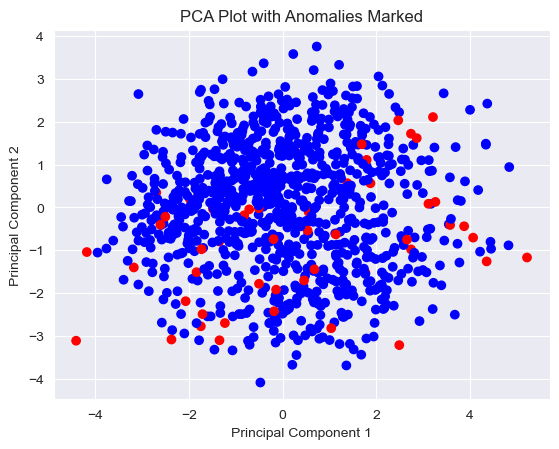

In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

identifiers = demog_df_one_student_ft_reduced[['SurveyNr', 'egoid']]
demog_df_one_student_ft_reduced.set_index(['SurveyNr', 'egoid'], inplace=True)

scaler = StandardScaler()
# Select only numeric data, excluding the index
df_scaled = scaler.fit_transform(demog_df_one_student_ft_reduced.select_dtypes(include=[np.number]))

# Convert scaled data back to DataFrame, ensuring the original index is preserved
df_scaled = pd.DataFrame(df_scaled, index=demog_df_one_student_ft_reduced.index, columns=demog_df_one_student_ft_reduced.select_dtypes(include=[np.number]).columns)

# Initialize Isolation Forest and fit/predict anomalies
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
preds = iso_forest.fit_predict(df_scaled)

# Assign the predictions as a new column in your DataFrame
df_scaled['anomaly'] = preds

# Filter the data based on the anomaly detection
df_clean = df_scaled[df_scaled['anomaly'] == 1]
df_anomalies = df_scaled[df_scaled['anomaly'] == -1]

# Apply PCA for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_scaled.drop('anomaly', axis=1))
principal_df = pd.DataFrame(data=principalComponents, 
                            index=df_scaled.index,  # Preserve original index
                            columns=['principal component 1', 'principal component 2'])


if not principal_df.index.equals(df_scaled.index):
    principal_df.set_index(df_scaled.index, inplace=True)
principal_df['anomaly'] = df_scaled['anomaly']

# Plotting
fig, ax = plt.subplots()
colors = {1: 'blue', -1: 'red'}
ax.scatter(principal_df['principal component 1'], principal_df['principal component 2'], 
           c=principal_df['anomaly'].apply(lambda x: colors[x]))
plt.title('PCA Plot with Anomalies Marked')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Analyze df_anomalies to see if the entities detected as anomalies have something in common 

In [89]:
anomalies_stats = df_anomalies.describe()
clean_data_stats = df_clean.describe()

# Compare the outputs
print("Anomalies Statistics:\n", anomalies_stats)
print("\nClean Data Statistics:\n", clean_data_stats)

Anomalies Statistics:
        enjoy_music  enjoy_outdoor  marijuana  enjoy_books  fswelfare  \
count    50.000000      50.000000  50.000000    50.000000  50.000000   
mean     -0.259506      -0.757647   0.176802    -0.290102   0.053000   
std       1.132901       1.359179   1.096669     1.279227   1.130664   
min      -2.551111      -2.904932  -1.088567    -3.609377  -1.270199   
25%      -1.438682      -1.656510  -1.088567    -0.723051  -1.270199   
50%      -0.326252      -0.408089   0.229525     0.720112  -0.388066   
75%       0.786177       0.840333   1.547618     0.720112   1.376198   
max       0.786177       2.088754   2.865710     0.720112   1.376198   

       wellbeing5  enjoy_follow_sports  wellbeing2     lesseq     weight  ...  \
count   50.000000            50.000000   50.000000  50.000000  50.000000  ...   
mean    -0.644771            -0.486081   -0.871821   0.861863  -0.002257  ...   
std      1.228833             1.148468    1.221350   1.109394   1.125944  ...   
min 

Shape Comparison: Normalizing the counts to densities allows for a direct comparison of the shapes of the distributions, providing insights into differences in the underlying distributions of anomalous vs. normal data.
Identifying Key Features: Certain features might show distinct distribution shapes for anomalies, which could help identify driving factors for these outliers.

IMPORTNAT ABOUT INTERPRETATION: 

Peaks in the Density Plot: Peaks or areas of higher density in the plot for outliers suggest that these values are more frequent among outliers compared to other values within the outlier subset.
Comparative Analysis: If these peaks differ significantly from the peaks or general shape of the density plot for normal data, it suggests that these feature values are particularly associated with being an outlier.

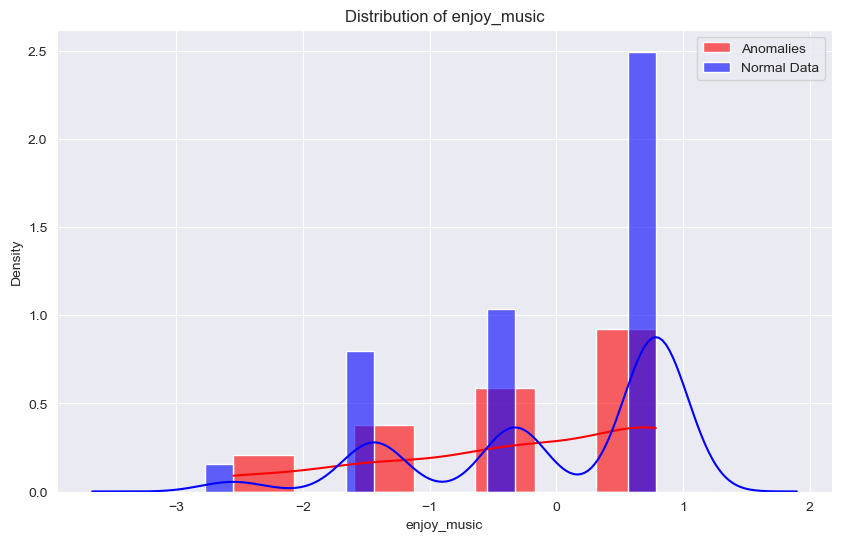

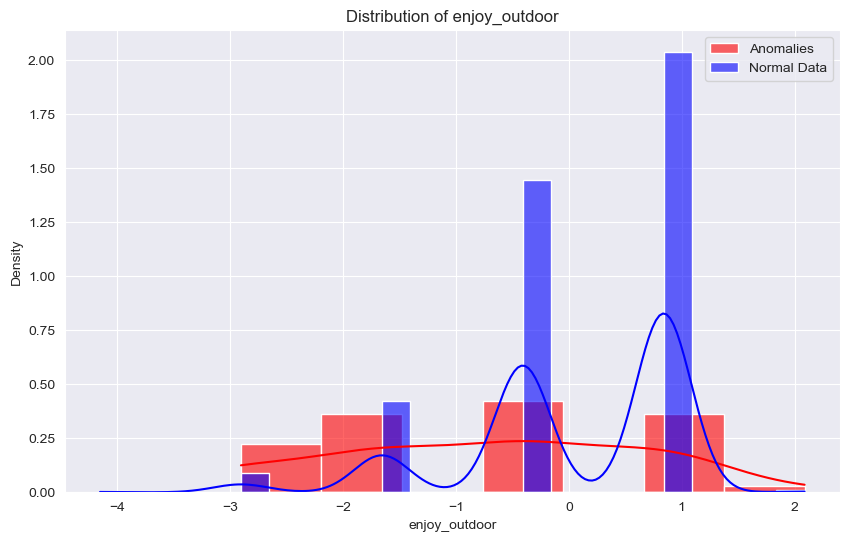

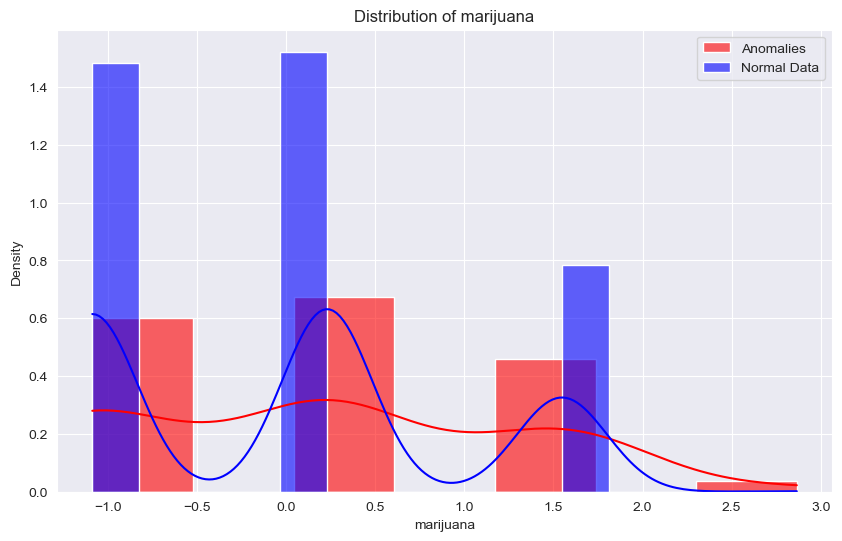

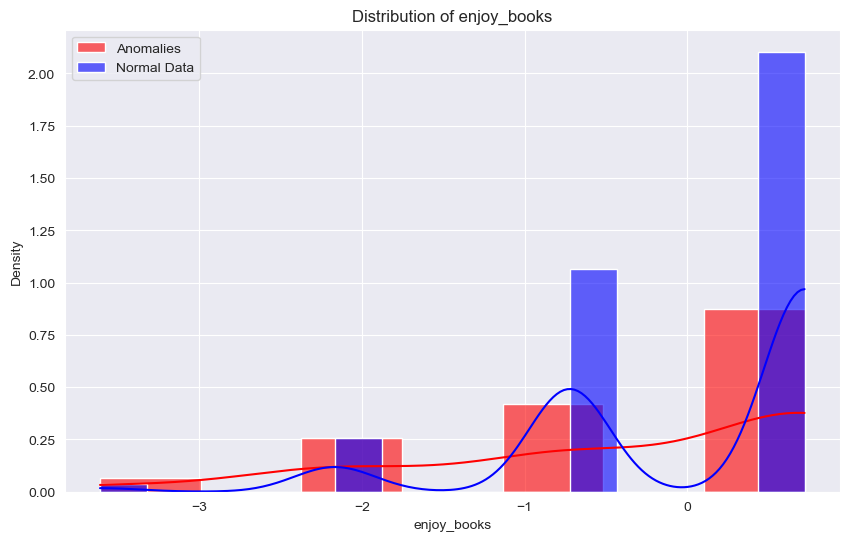

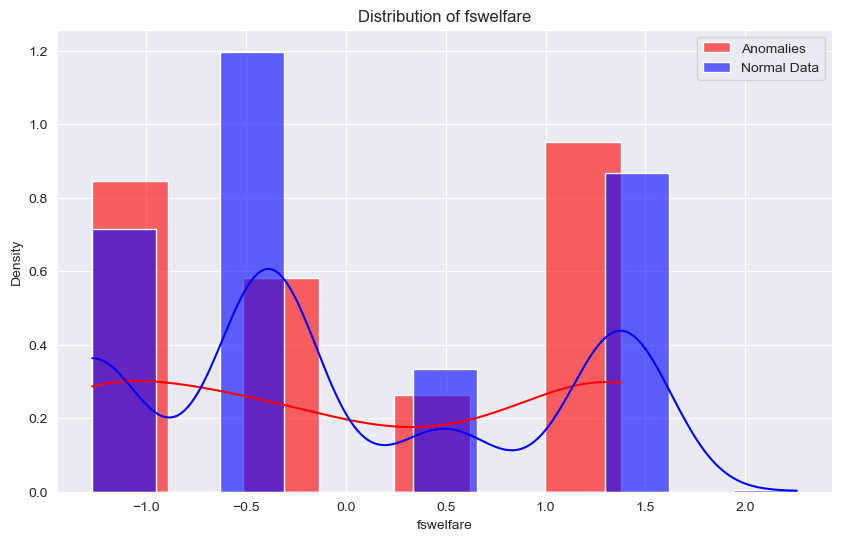

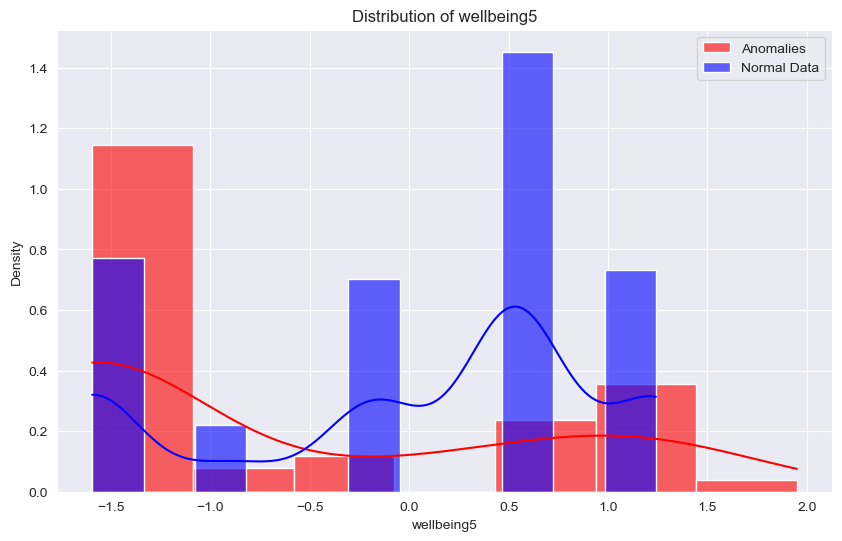

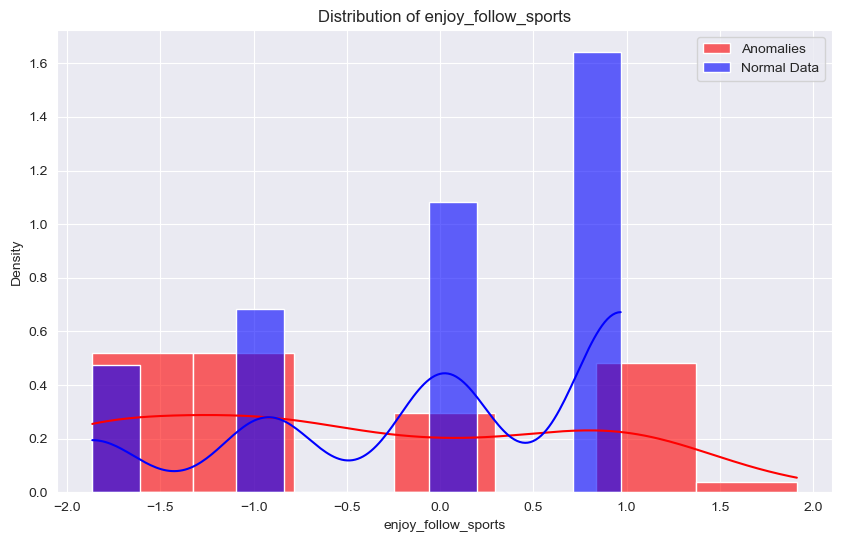

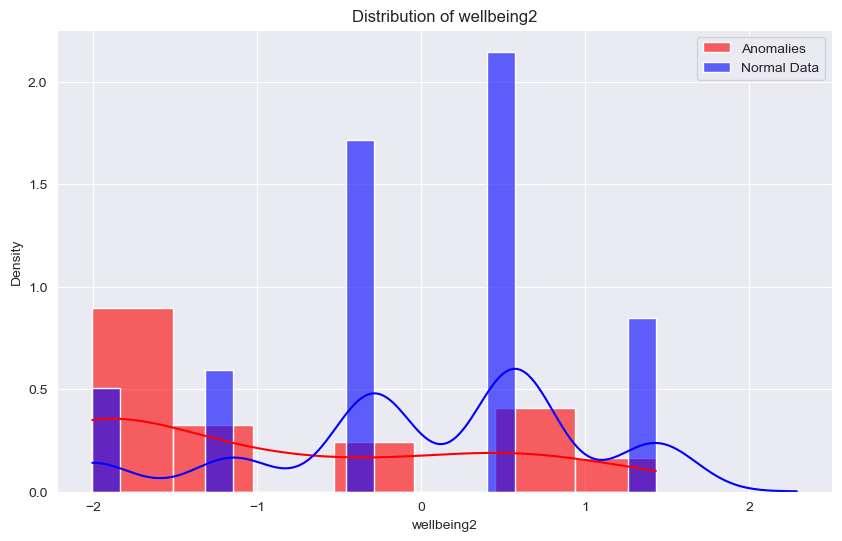

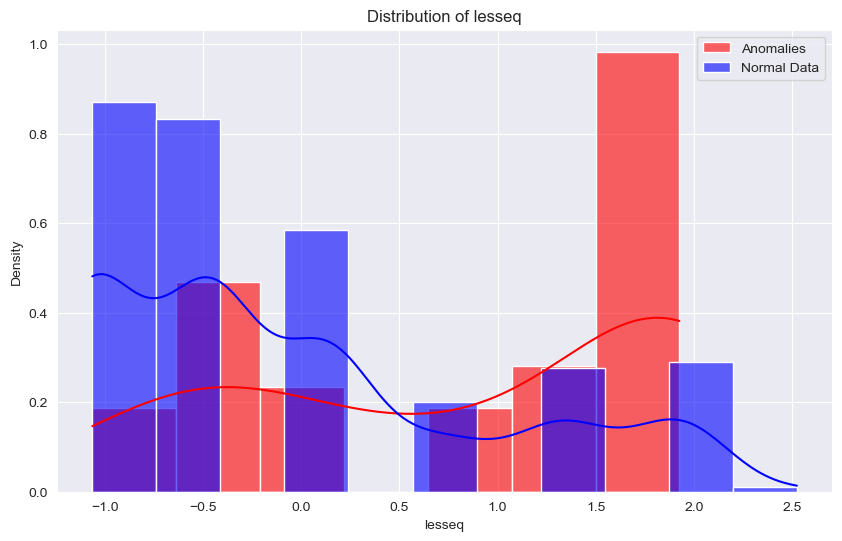

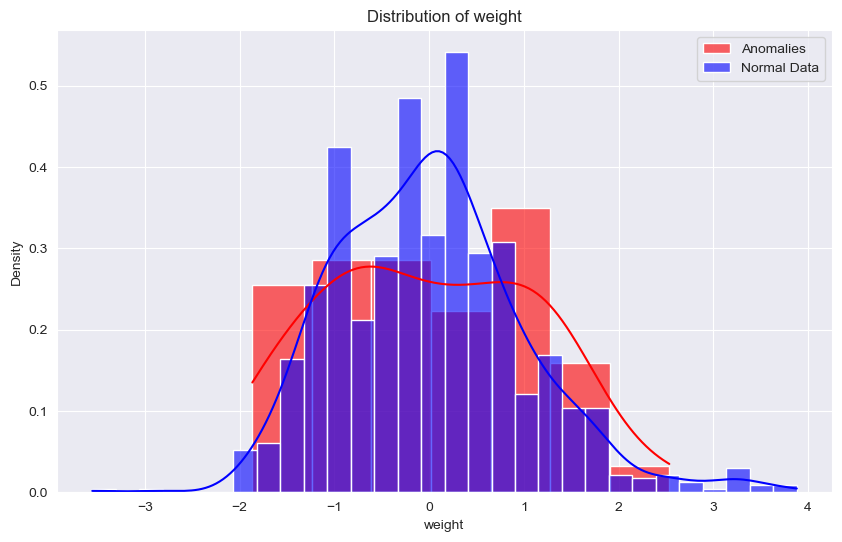

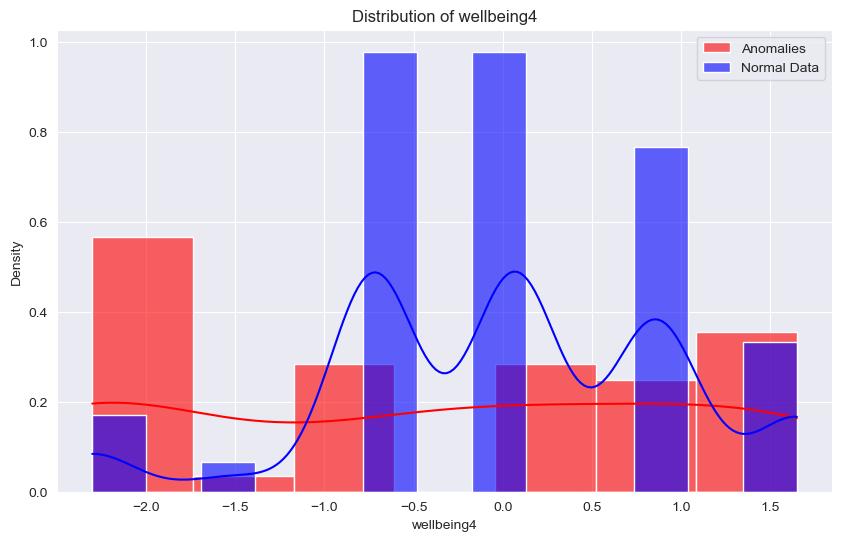

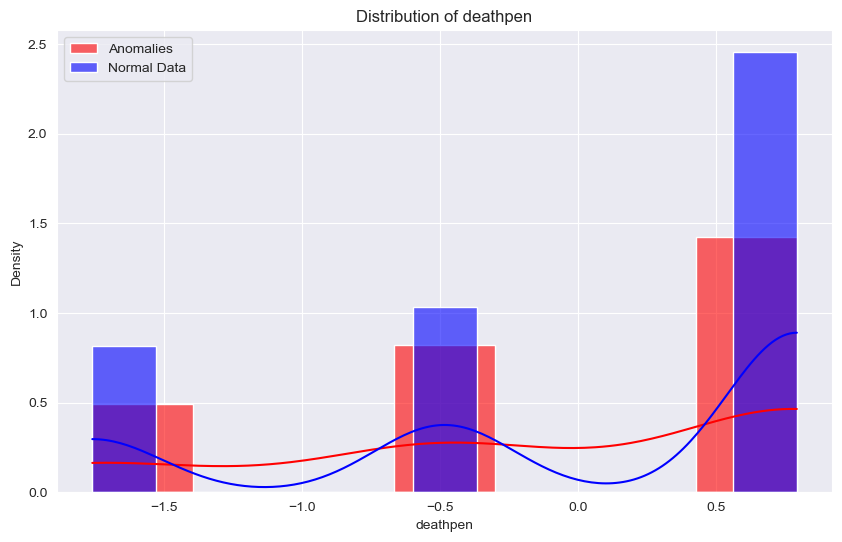

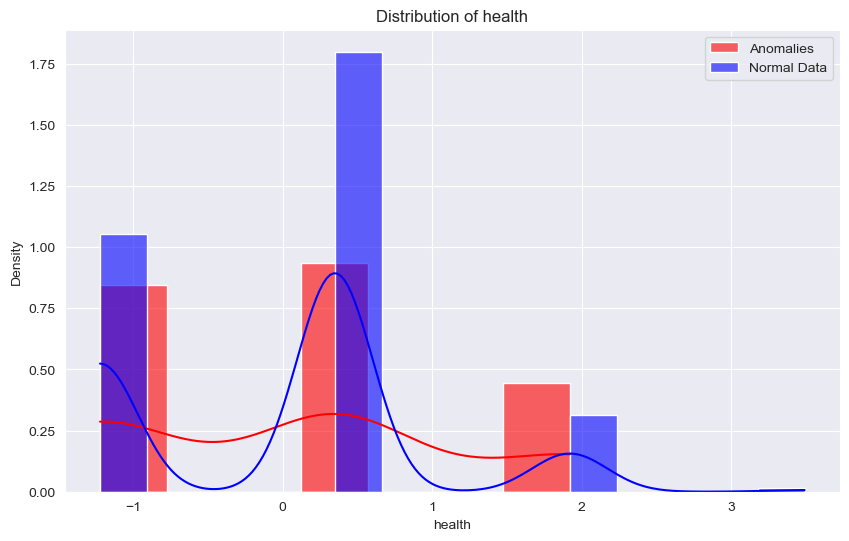

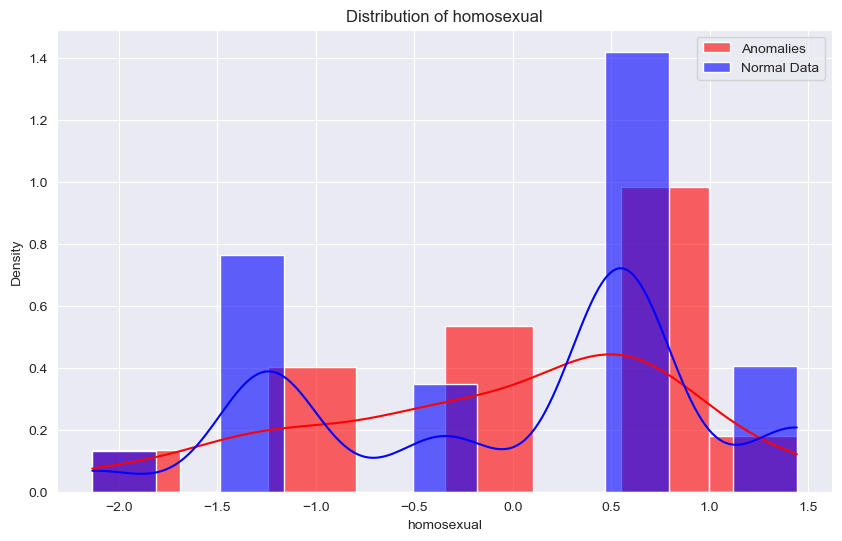

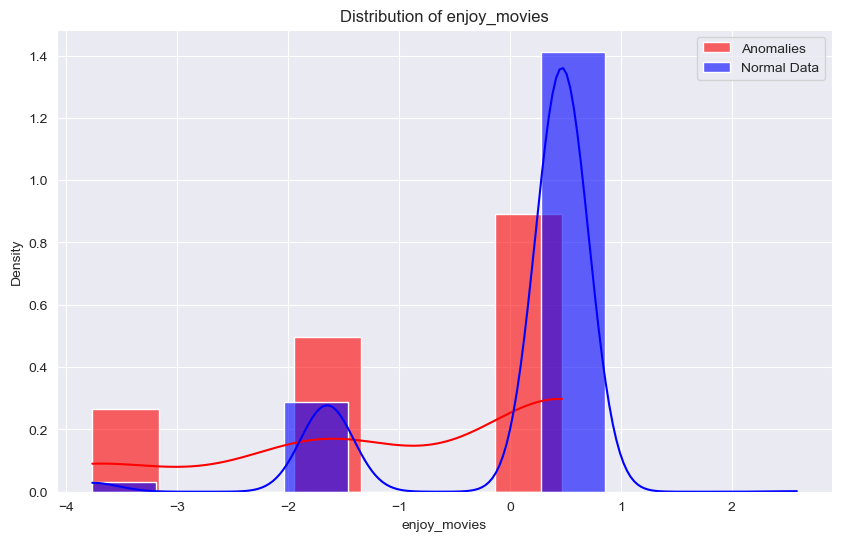

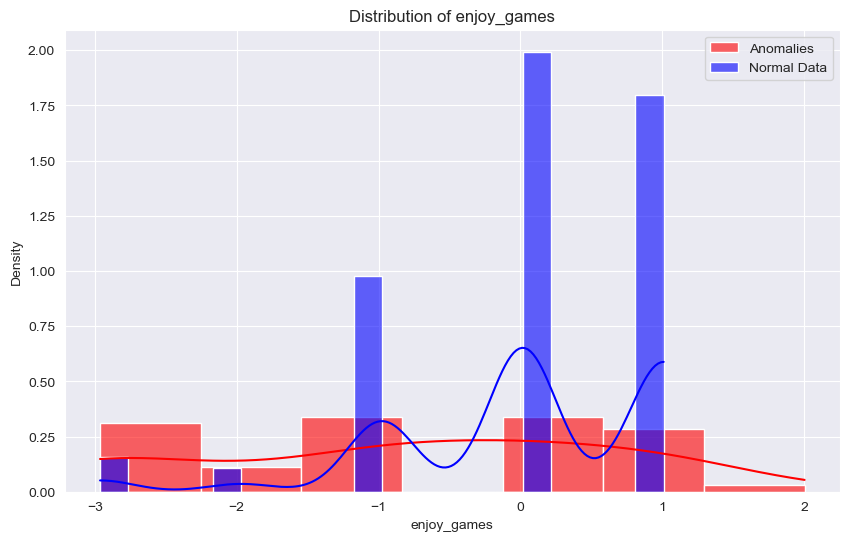

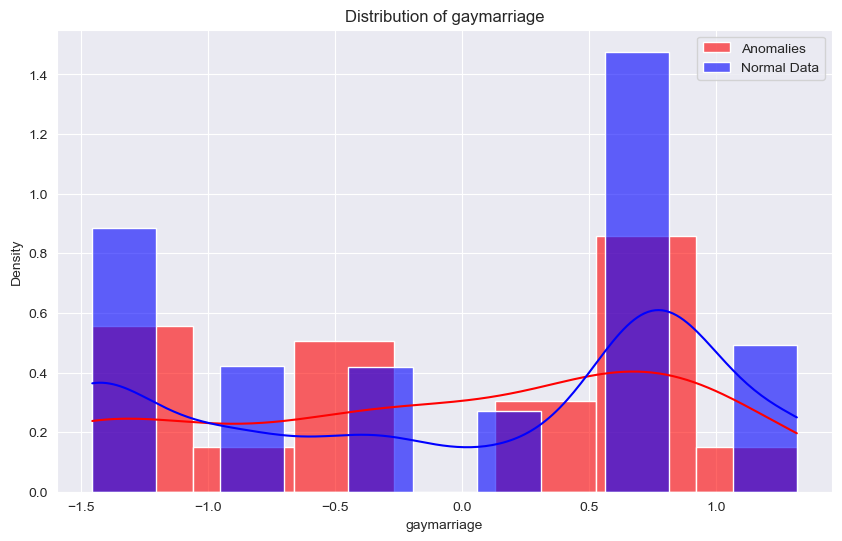

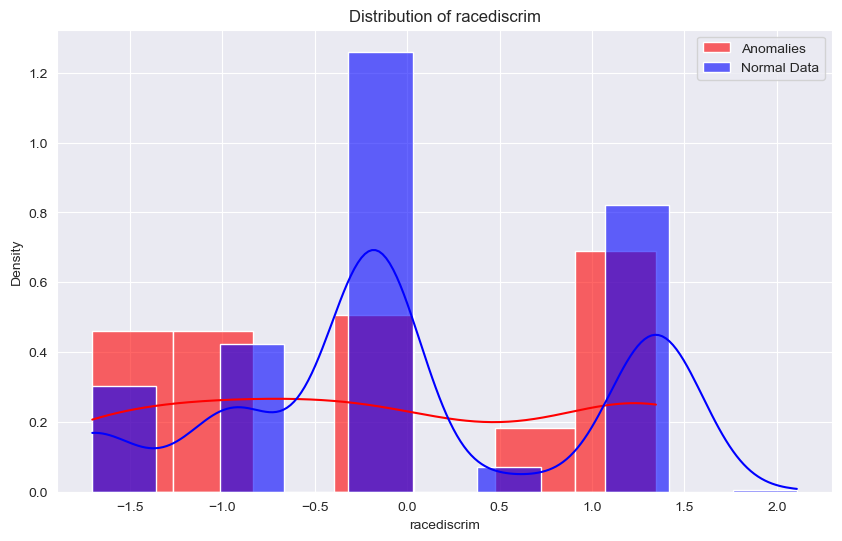

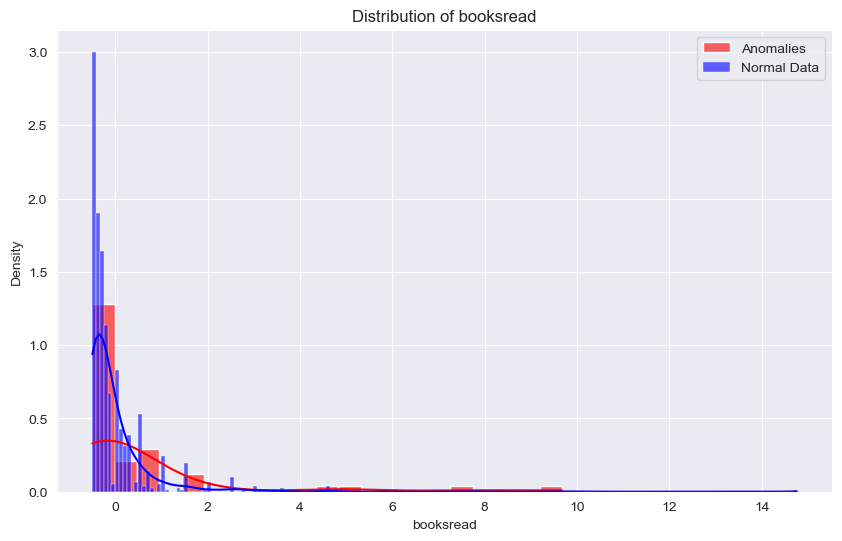

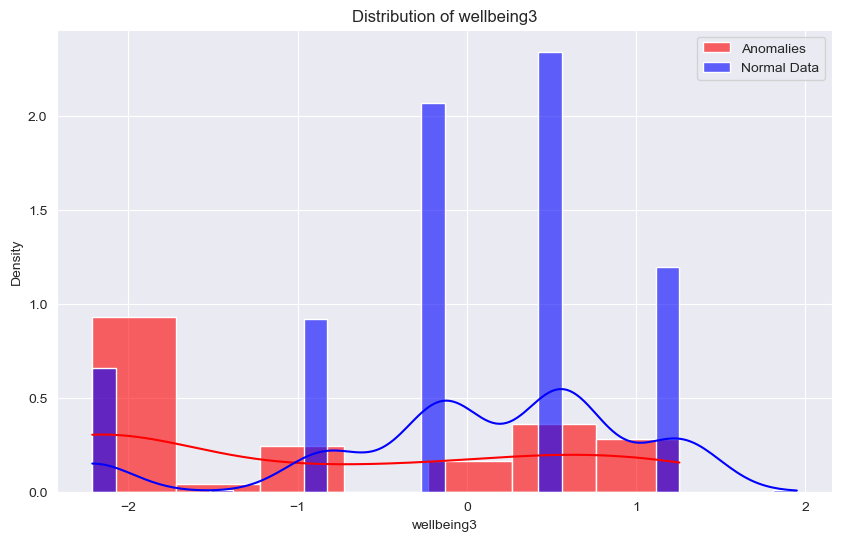

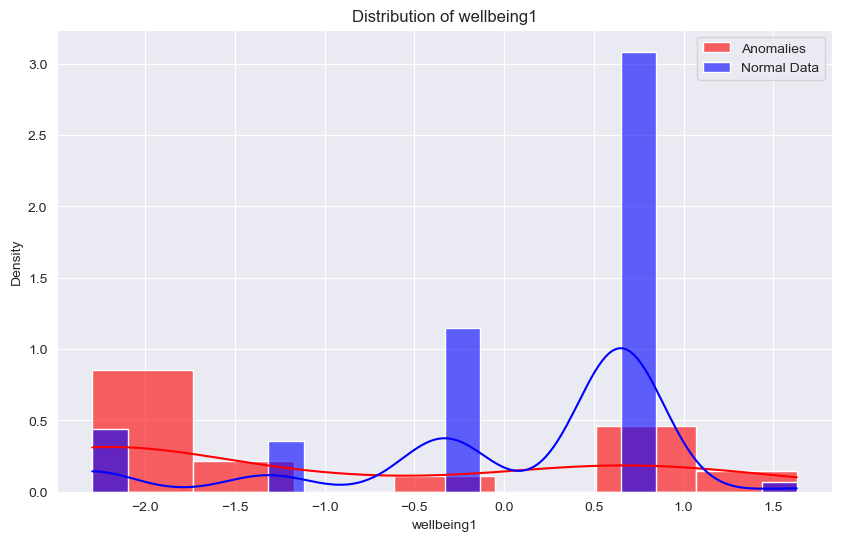

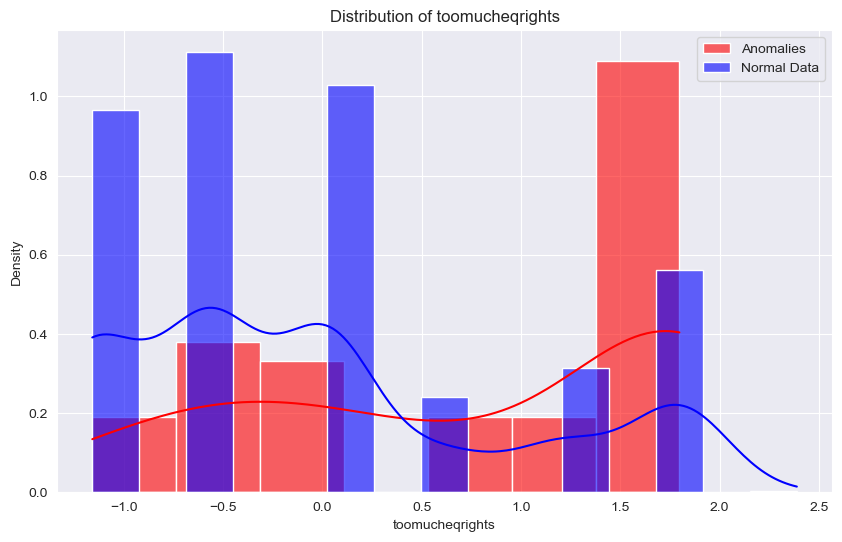

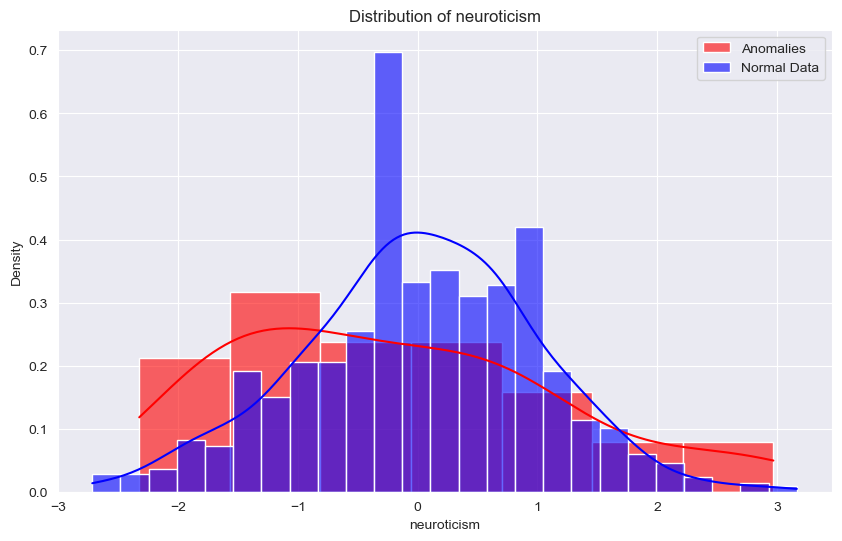

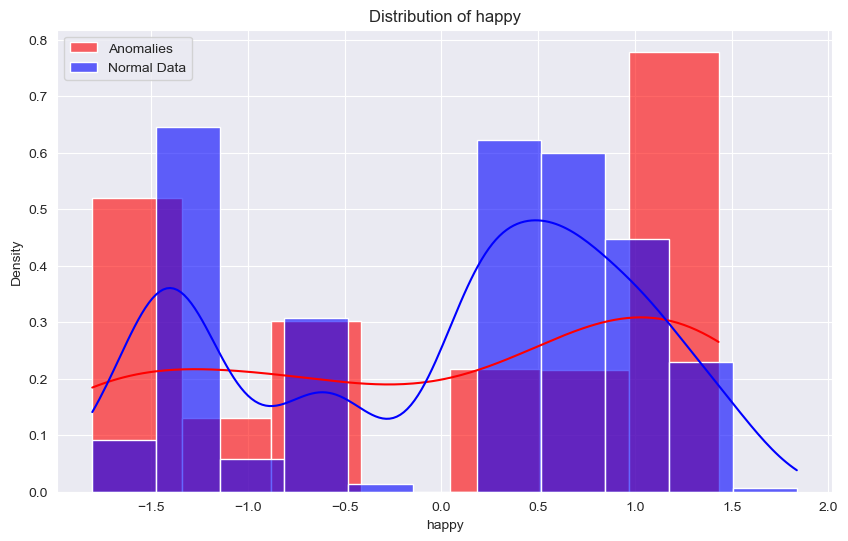

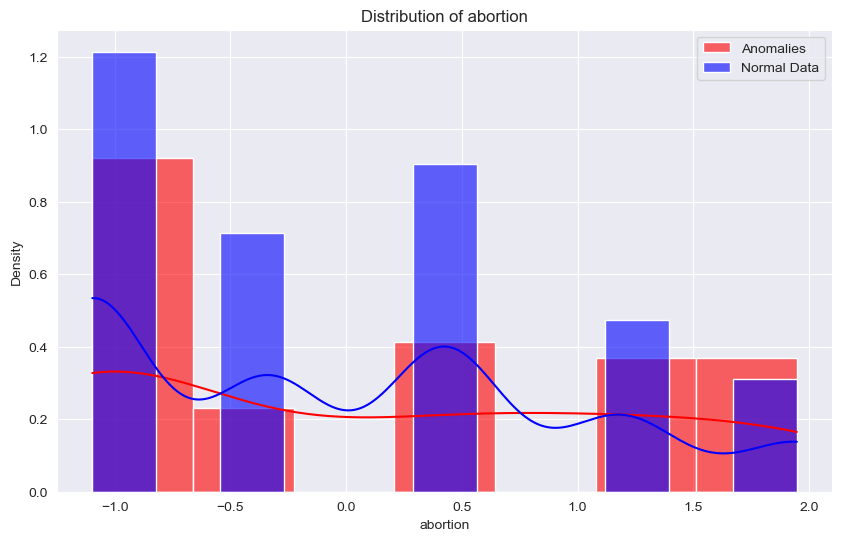

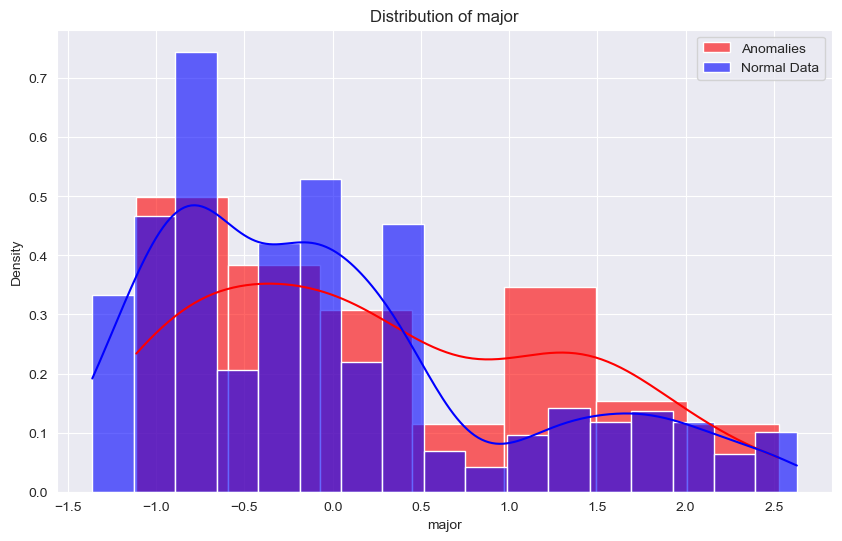

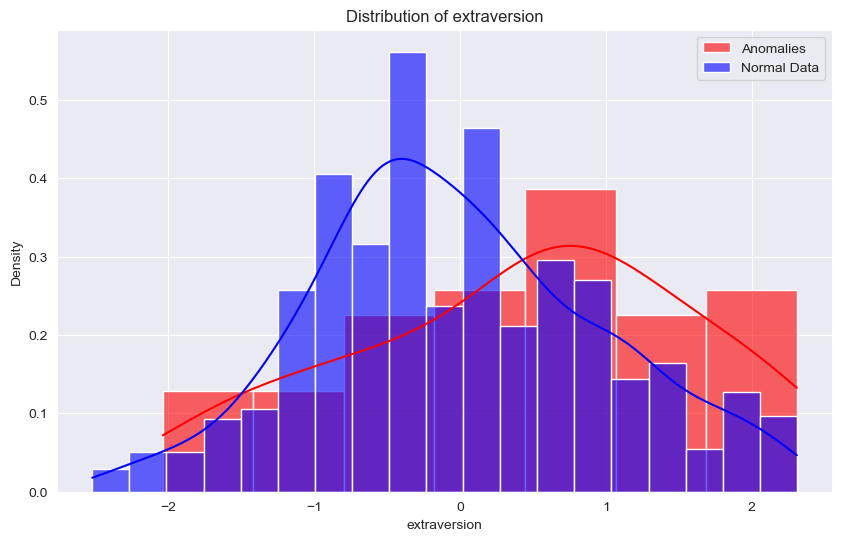

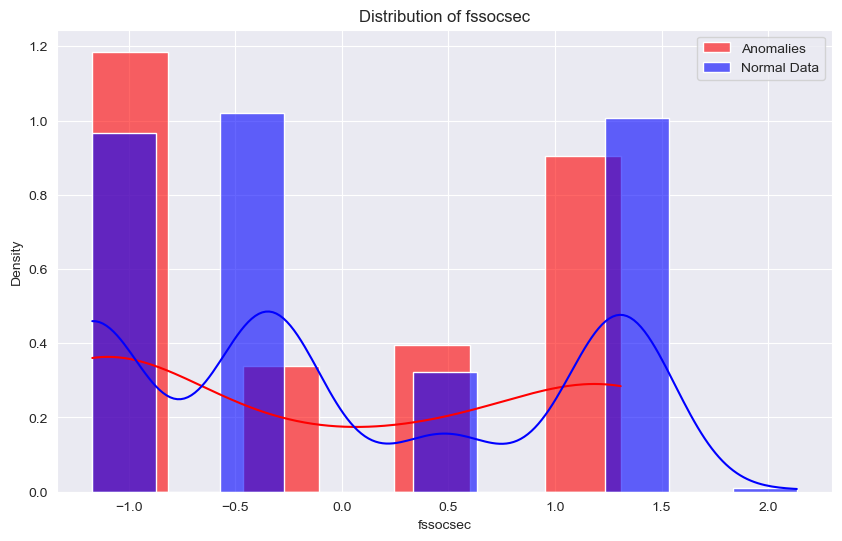

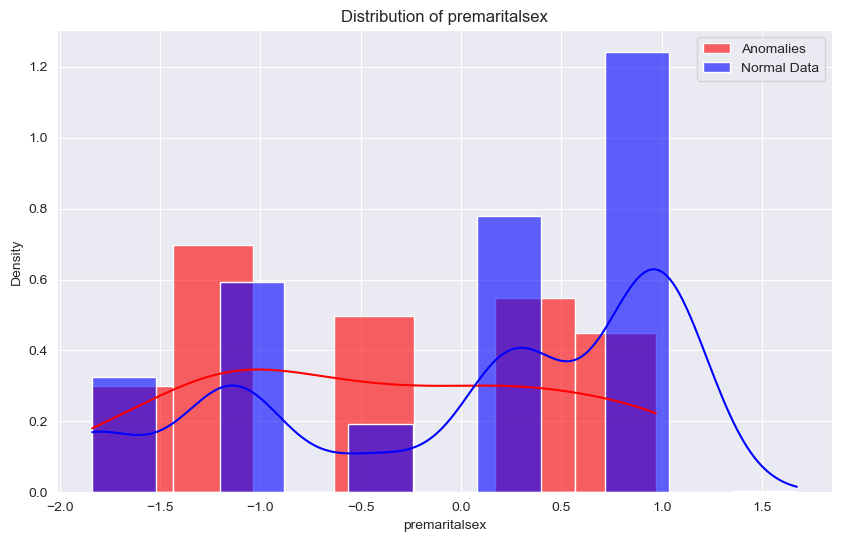

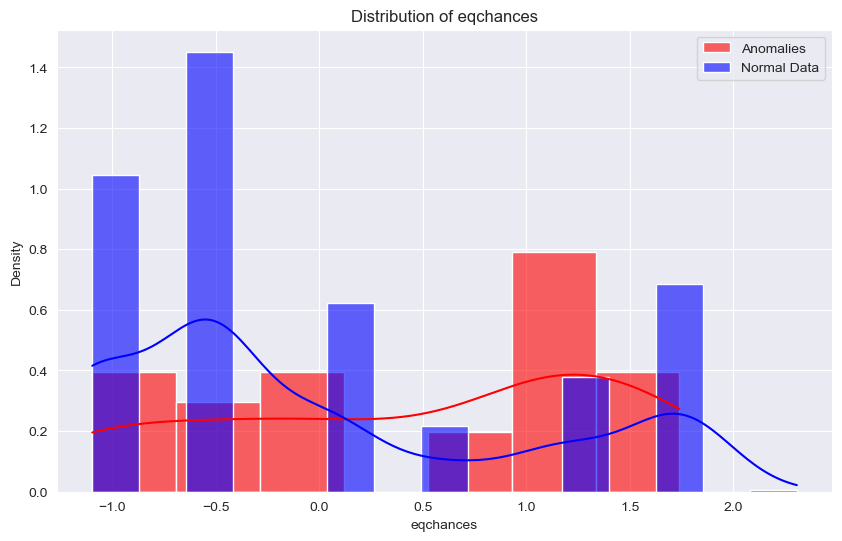

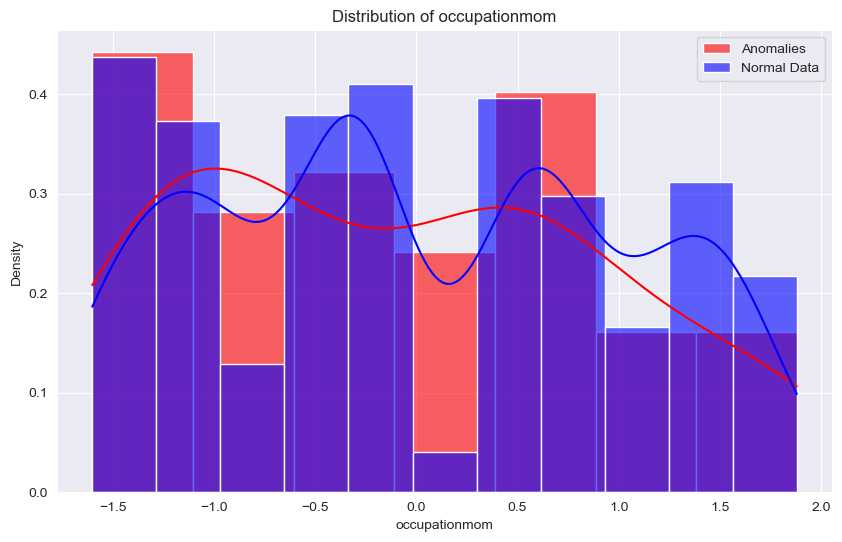

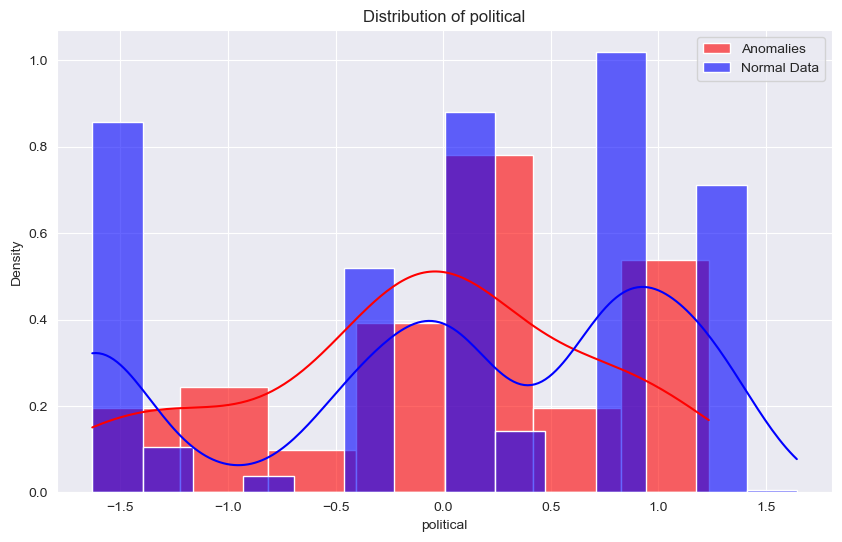

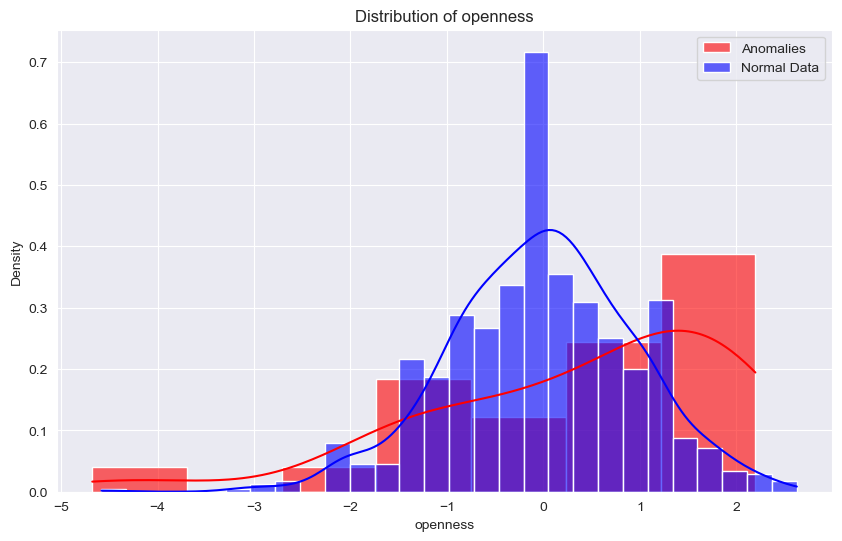

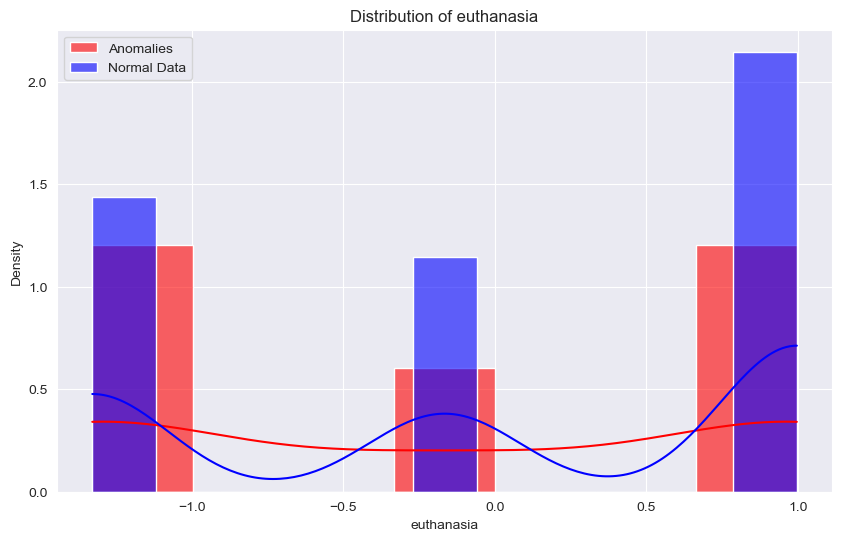

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_anomalies and df_clean are your dataframes
for column in df_anomalies.columns[:-1]:  # Exclude 'anomaly' column
    plt.figure(figsize=(10, 6))
    # Plot density histograms for both anomalous and normal data
    sns.histplot(df_anomalies[column], kde=True, stat="density", color='red', label='Anomalies', alpha=0.6)
    sns.histplot(df_clean[column], kde=True, stat="density", color='blue', label='Normal Data', alpha=0.6)
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()


Check for correlations with the anomalous data, Sometimes anomalies are driven by specific relationships between variables that don't appear in normal data

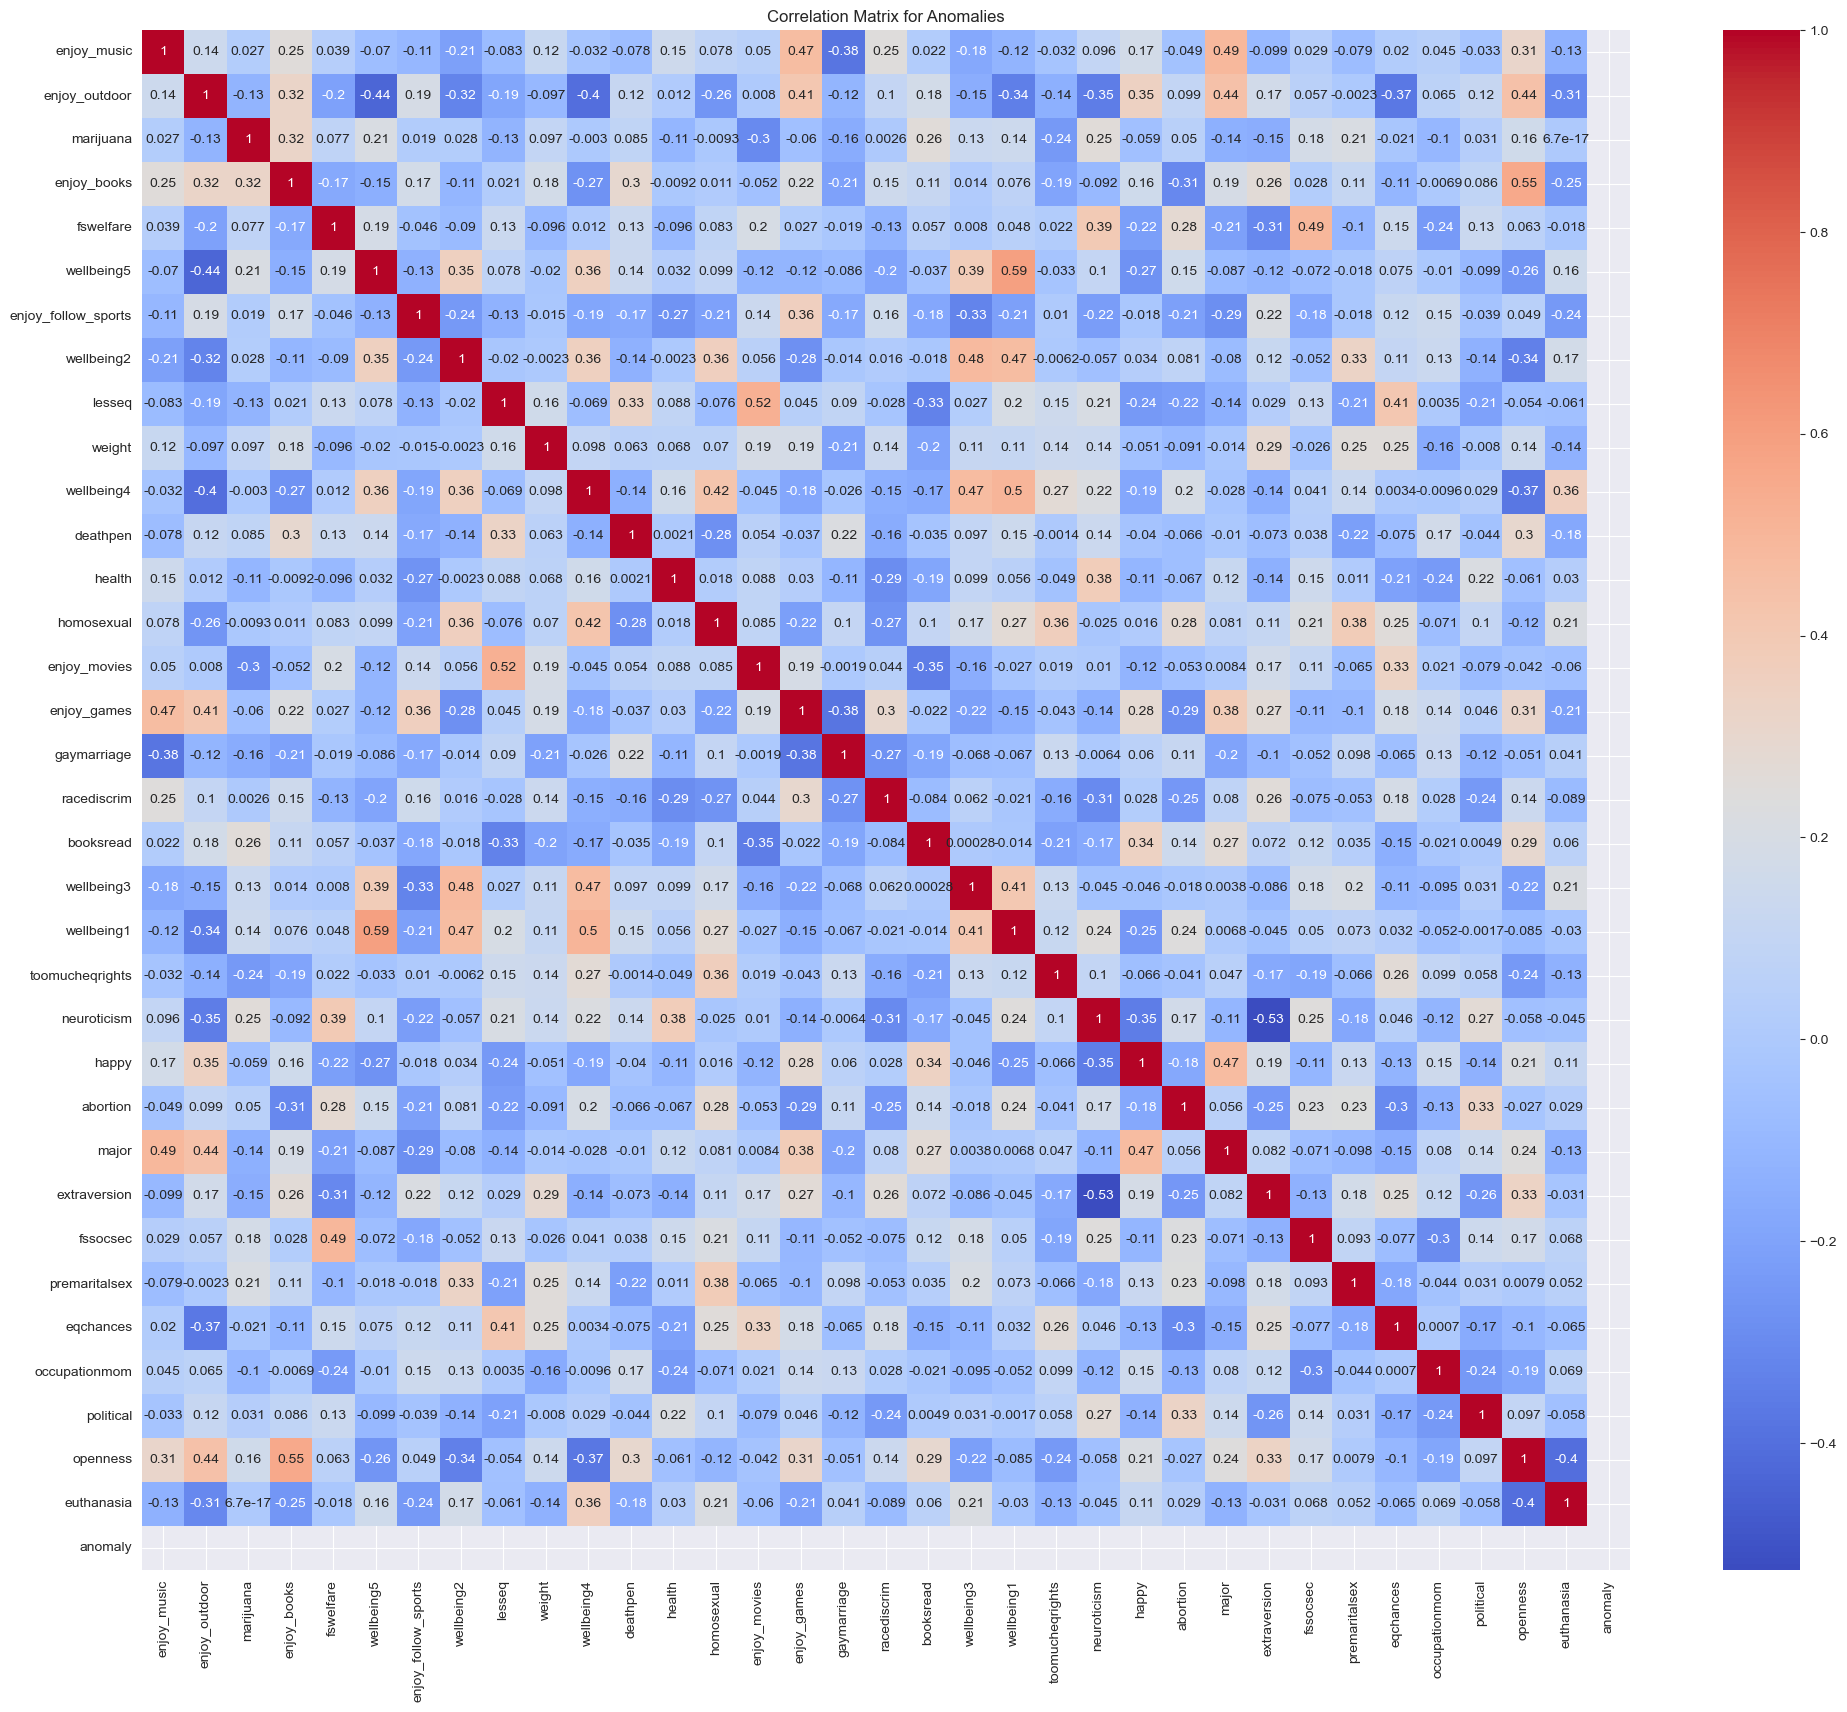

In [94]:
# Correlation matrix for anomalies
anomalies_corr = df_anomalies.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(anomalies_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Anomalies')
plt.show()


Moderate Correlation: Values around ±0.5 to ±0.8 suggest a moderate relationship.
We can observe moderate relationships between features. Mostly between wellbeingx vs wellbeingy and enjoy_books vs openness

Cluster Analysis for anomalies data

C:\Users\Michalina\miniconda3\envs\coding-fairness\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


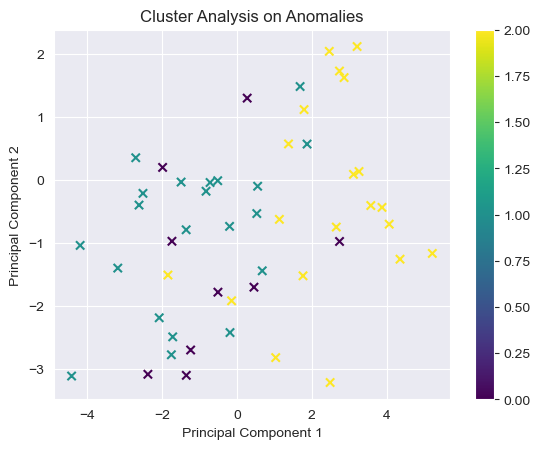

In [97]:
from sklearn.cluster import KMeans

# Assuming PCA has already reduced the dimensionality appropriately
kmeans = KMeans(n_clusters=3, random_state=42)
anomaly_clusters = kmeans.fit_predict(df_anomalies.drop('anomaly', axis=1))

# Visualize the clusters
plt.scatter(principal_df.loc[df_anomalies.index, 'principal component 1'],
            principal_df.loc[df_anomalies.index, 'principal component 2'],
            c=anomaly_clusters, cmap='viridis', marker='x')
plt.title('Cluster Analysis on Anomalies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


In [100]:
demog_df_one_student_ft_reduced = demog_df_one_student_ft_reduced.reset_index()
demog_df_one_student_ft_reduced = demog_df_one_student_ft_reduced[demog_df_one_student_ft_reduced['SurveyNr']!= 1]
df_scaled = df_scaled.reset_index()
df_scaled = df_scaled[df_scaled['SurveyNr'] != 1]

In [101]:
dir_path = r'C:\Users\Michalina\MasterThesis\PWR\coding-fairness\Demographic_Features'

In [102]:

df_scaled.to_csv(dir_path  + 'Student_Single_Features_No_Anomalies.csv', index=False)

In [ ]:
demog_df_one_student_ft_reduced.to_csv(dir_path + 'Student_Single_Features.csv', index=False)  

In [104]:
from helpers import report_missing_data, reduce_features_via_clustering
import pandas as pd
import numpy as np

dir_path = r'C:\Users\Michalina\MasterThesis\PWR\coding-fairness\Demographic_Features'
demog_df_one_student_ft_reduced = pd.read_csv(dir_path +  'Student_Single_Features_No_Anomalies.csv')
col_missing_percentage, row_missing_percentage = report_missing_data(demog_df_one_student_ft_reduced)



No missing data in any column.
No missing data in any row.


Elimination fo the features based on their absence (Amputation)  
Threshold of Missing Values which indicates amputation of a feature when we have more than this threshold of values missing: 30%

In [ ]:
missing_percentage = demog_df.isnull().mean() * 100
threshold = 20
columns_to_drop = missing_percentage[missing_percentage >= threshold].index # series datatype which have te columns name as the index
print("Columns to drop: ")
print(columns_to_drop)
demog_df.drop(columns=columns_to_drop, inplace=True)
demog_df.info()


Amputation of rows when the threshold f missing values is less than 5 percent

In [ ]:
from helpers import drop_missing_data 
demog_df = drop_missing_data(demog_df, 15)
# Display the updated DataFrame info
print("\nDataFrame after deleting rows with >15% missing data:")
print(demog_df.info())


Now I want to use Imputation method in order to get rid of missing values in a range of 5percent to 20 percent (Column wisely)

In [ ]:
from helpers import identify_column_types
import numpy as np

categorical_cols, numerical_cols = identify_column_types(demog_df, exclude_numerical=['egoid', 'SurveyNr'])



We have mixed float values with string values for categorical features 

   
- I need to map the features into the numerical scale which describe the order or intensity and then try to map it with the numerical values 

#we want to have the information about the ordinality of data

In [ ]:
#TODO : THINK ABOUT THE WAY how to map numerical values in categorical data which are ordinal data

In [ ]:
#GOING AROUND the problm -> map numerical values in ategorical features as unknown'strings
import pandas as pd
from helpers import process_and_encode_categorical
demog_df = process_and_encode_categorical(demog_df, categorical_cols)
print(demog_df.head())


In [ ]:

"""
# Later in your code, to reverse the transformation
demog_df[categorical_cols] = encoder.inverse_transform(demog_df[categorical_cols])

print("Restored categorical values:")
print(demog_df[categorical_cols].head())
"""


In [ ]:
from helpers import impute_missing_values
# Imputing numerical data
demog_df = impute_missing_values(demog_df, numerical_cols, categorical_cols)

Delete unecessary columns

In [ ]:
# Find columns that contain the substring 'completed'
cols_to_delete = [col for col in demog_df.columns if 'lastpageseen' in col]

demog_df.drop(columns =cols_to_delete, inplace=True)

cols_to_delete = [col for col in demog_df.columns if 'completed' in col]

demog_df.drop(columns =cols_to_delete, inplace=True)
demog_df

cols_to_delete = [col for col in demog_df.columns if 'merge' in col]

demog_df.drop(columns =cols_to_delete, inplace=True)

cols_to_delete = [col for col in demog_df.columns if 'sender' in col]

demog_df.drop(columns =cols_to_delete, inplace=True)

cols_to_delete = [col for col in demog_df.columns if 'duplicate' in col]

demog_df.drop(columns =cols_to_delete, inplace=True)

In [ ]:
# Calculate the percentage of missing data per row
from helpers import calculate_missing_data

row_missing, col_missing = calculate_missing_data(demog_df)

print(row_missing)
print(col_missing)

In [ ]:
print("Descriptive Statistics:")
print(demog_df.describe())

Feature Selection - Unsupervised technique, Variance Threshold

  Eliminate features with no or little variance

In [ ]:
from helpers import remove_low_variance_features
demog_df_reduced = remove_low_variance_features(demog_df, threshold=0.2)

print(f"Reduced from {demog_df.shape[1]} to {demog_df_reduced.shape[1]} features.")

Identify Highly Correlated Features

In [ ]:
# Calculate correlation matrix
from helpers import remove_highly_correlated_features
demog_df_reduced = remove_highly_correlated_features(demog_df_reduced, correlation_threshold=0.95)

Feature Selection - Unsupervised technique, Mutual Information 
https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a

Mutual Information (MI) is a non-linear statistic that measures the dependency between variables. It is particularly useful for feature selection as it can capture any kind of relationship, not just linear, unlike Pearson correlation.  


Mutual Information can help identify features that share the most information with each other, thus highlighting the dependencies and redundancies within the dataset.  

Is Mutual Information a Good Way to Determine Relevant Features?  


**Advantages:**    

- Non-linear Relationships: MI can capture non-linear relationships between features, which correlation metrics might miss.  
- General Applicability: Works with both continuous and categorical data.  

Cluster Analysis

This method groups features that are similar to each other based on their correlations or other similarity metrics. Highly correlated features are likely to be redundant, and you can choose one feature from each cluster.

In [ ]:
from helpers import reduce_features_via_clustering

reduced_features = reduce_features_via_clustering(demog_df_reduced, distance_threshold=0.5)

print(f"Original number of features: {demog_df_reduced.shape[1]}")
print(f"Reduced number of features: {reduced_features.shape[1]}")


Model Input Creation: Merging Demographic Information with simulation results

Input: We get the entry from the simulation (EgoID, predicted value, real,value)
We concatenate this with the demog vector feature by the egoid value

Entry == all of the sim entries with cocncatenated demog features
Output: Missclassified == (predicted_opinion_value == real_opinion_value)
Input: Entry / {Output}



In [105]:
import pandas as pd
import glob

# Define the path pattern
path_pattern = r"C:\Users\Michalina\MasterThesis\PWR\coding-fairness\dataset\simulationResults\*.csv"

# Specify the columns to extract
columns = ['StudentID', 'SurveyNr', 'OpinionSim', 'OpinionSurvey']

# Initialize a list to store DataFrames
data_frames = []

# Read all CSV files matching the path pattern
for f in glob.glob(path_pattern):
    try:
        # Read the CSV file with the correct delimiter
        df = pd.read_csv(f, delimiter=';', usecols=lambda column: column in columns)
        # Append the DataFrame if it contains any of the required columns
        if not df.empty:
            data_frames.append(df)
    except ValueError as e:
        print(f"Error reading {f}: {e}")
    except Exception as e:
        print(f"Unexpected error with file {f}: {e}")

# Check if any DataFrames were loaded and concatenate them
if data_frames:
    final_df = pd.concat(data_frames, ignore_index=True)
    print(final_df)
else:
    print("No data frames were loaded, check file paths and column names.")


# Rename 'StudentID' to 'egoid'
final_df.rename(columns={'StudentID': 'egoid'}, inplace=True)
# Display the DataFrame to confirm the change

final_df = final_df.reset_index(drop=True)
demog_df_one_student_ft_reduced = demog_df_one_student_ft_reduced.reset_index(drop=True)

demog_df_one_student_ft_reduced['egoid'] = demog_df_one_student_ft_reduced['egoid'].astype('int64')
demog_df_one_student_ft_reduced['SurveyNr'] = demog_df_one_student_ft_reduced['SurveyNr'].astype('int64')


      

        StudentID  SurveyNr         Question  OpinionSim  OpinionSurvey
0           20905         1       euthanasia           0              0
1           13116         1       euthanasia           1              1
2           75178         1       euthanasia           1              1
3           30952         1       euthanasia           2              2
4           60830         1       euthanasia           1              1
...           ...       ...              ...         ...            ...
470875      73303         6  toomucheqrights           2              1
470876      69065         5  toomucheqrights           2              1
470877      69065         6  toomucheqrights           2              0
470878      63063         6  toomucheqrights           2              0
470879      73175         6  toomucheqrights           2              0

[470880 rows x 5 columns]


DATA WITH 26 SELECTED FEATURES DIRECTLY ASSOC WITH A STUDENT 

In [108]:
# Perform join merge
demog_data_students_2 = final_df.merge(demog_df_one_student_ft_reduced, on=['egoid', 'SurveyNr'], how='inner')
print(demog_data_students_2.head())
# Check the information about the merged DataFrame to understand the changes
print(demog_data_students_2.info())

   egoid  SurveyNr    Question  OpinionSim  OpinionSurvey  enjoy_music  \
0  85596         2  euthanasia           1              0     0.786177   
1  25323         2  euthanasia           0              1     0.786177   
2  63188         2  euthanasia           1              0     0.786177   
3  22931         2  euthanasia           0              0    -0.326252   
4  75261         2  euthanasia           0              1     0.786177   

   enjoy_outdoor  marijuana  enjoy_books  fswelfare  ...     major  \
0      -1.656510   0.229525     0.720112  -1.270199  ... -0.164639   
1      -0.408089   1.547618     0.720112  -0.388066  ... -0.563837   
2      -1.656510   0.229525     0.720112  -1.270199  ...  0.484058   
3      -0.408089   0.229525    -0.723051   1.376198  ... -0.114739   
4       0.840333  -1.088567     0.720112   0.494066  ... -1.212533   

   extraversion  fssocsec  premaritalsex  eqchances  occupationmom  political  \
0      0.377495 -1.171878      -1.135394  -0.529150  

In [109]:
demog_data_students_2.drop_duplicates(inplace=True)
# Now final_df has a clean, sequential index starting from 0
demog_data_students_2['Y'] = (demog_data_students_2['OpinionSim'] != demog_data_students_2['OpinionSurvey']).astype(int)
# Display the DataFrame to verify the new column with integer encoding
print(demog_data_students_2[['OpinionSim', 'OpinionSurvey', 'Y']].head())
# Drop the columns 'OpinionSim' and 'OpinionSurvey'
demog_data_students_2.drop(columns=['OpinionSim', 'OpinionSurvey'], inplace=True)
# Display the DataFrame to verify that the columns have been removed
print(demog_data_students_2.head())

demog_data_students_2.drop_duplicates(inplace=True)
# Drop the columns 'OpinionSim' and 'OpinionSurvey'
demog_data_students_2.drop(columns=['SurveyNr'], inplace=True)
# Display the DataFrame to verify that the columns have been removed
print(demog_data_students_2.head())
# Remove duplicated rows
demog_data_students_2.drop_duplicates(inplace=True)
# Display the DataFrame to verify that duplicates have been removed
print("DataFrame after removing duplicates:")
print(demog_data_students_2.head())


   OpinionSim  OpinionSurvey  Y
0           1              0  1
1           0              1  1
2           1              0  1
3           0              0  0
4           0              1  1
   egoid  SurveyNr    Question  enjoy_music  enjoy_outdoor  marijuana  \
0  85596         2  euthanasia     0.786177      -1.656510   0.229525   
1  25323         2  euthanasia     0.786177      -0.408089   1.547618   
2  63188         2  euthanasia     0.786177      -1.656510   0.229525   
3  22931         2  euthanasia    -0.326252      -0.408089   0.229525   
4  75261         2  euthanasia     0.786177       0.840333  -1.088567   

   enjoy_books  fswelfare  wellbeing5  enjoy_follow_sports  ...  extraversion  \
0     0.720112  -1.270199    0.532063            -0.920636  ...      0.377495   
1     0.720112  -0.388066    0.532063             0.024050  ...     -0.588123   
2     0.720112  -1.270199    0.532063             0.024050  ...     -0.105314   
3    -0.723051   1.376198    0.532063        

DATA WITH MORE FEATURES (AROUND 126)

In [110]:
demog_data_students_2.to_csv(dir_path + 'Student_Single_Features_With_Y.csv', index=False) 

In [ ]:
final_df.sort_values(by=['egoid'])
final_df

# Reset the index of the DataFrame and drop the old index
final_df = final_df.reset_index(drop=True)
demog_df_reduced = demog_df_reduced.reset_index(drop=True)

print(final_df[['egoid', 'SurveyNr']].dtypes)
print(demog_df_reduced[['egoid', 'SurveyNr']].dtypes)

demog_df_reduced['egoid'] = demog_df_reduced['egoid'].astype('int64')
demog_df_reduced['SurveyNr'] = demog_df_reduced['SurveyNr'].astype('int64')

print(final_df[['egoid', 'SurveyNr']].dtypes)
print(demog_df_reduced[['egoid', 'SurveyNr']].dtypes)



# Perform join merge
demog_data_students = final_df.merge(demog_df_reduced, on=['egoid', 'SurveyNr'], how='inner')
print(demog_data_students.head())
# Check the information about the merged DataFrame to understand the changes
print(demog_data_students.info())

demog_data_students.drop_duplicates(inplace=True)
# Now final_df has a clean, sequential index starting from 0
# Convert boolean column to integer (1 for True, 0 for False)
demog_data_students['Y'] = (demog_data_students['OpinionSim'] == demog_data_students['OpinionSurvey']).astype(int)

# Display the DataFrame to verify the new column with integer encoding
print(demog_data_students[['OpinionSim', 'OpinionSurvey', 'Y']].head())
# Drop the columns 'OpinionSim' and 'OpinionSurvey'
demog_data_students.drop(columns=['OpinionSim', 'OpinionSurvey'], inplace=True)
# Display the DataFrame to verify that the columns have been removed
print(demog_data_students.head())

demog_data_students.drop_duplicates(inplace=True)
# Drop the columns 'OpinionSim' and 'OpinionSurvey'
demog_data_students.drop(columns=['SurveyNr'], inplace=True)
# Display the DataFrame to verify that the columns have been removed
print(demog_data_students.head())
# Remove duplicated rows
demog_data_students.drop_duplicates(inplace=True)
# Display the DataFrame to verify that duplicates have been removed
print("DataFrame after removing duplicates:")
print(demog_data_students.head())


HERE IS THE START POINT OF LOADING DATA AND TRAINING !!!!


Here use either demog_data_students_2 (around 20) or demog_data_students (more features 120)

In [113]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
dir_path = r'C:\Users\Michalina\MasterThesis\PWR\coding-fairness\Demographic_Features'
demog_data_students_2 = pd.read_csv(dir_path + 'Student_Single_Features_With_Y.csv') 
# Identify categorical columns
categorical_cols = demog_data_students_2.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)

label_encoder = LabelEncoder()
for col in categorical_cols:
    demog_data_students_2[col] = label_encoder.fit_transform(demog_data_students_2[col])

demog_data_students_2 = pd.get_dummies(demog_data_students_2, columns=categorical_cols)

# Check for missing values
print(demog_data_students_2.isnull().sum())

# Option to fill missing values
demog_data_students_2.fillna(demog_data_students_2.mean(), inplace=True) 

cols_to_delete = [col for col in demog_data_students_2.columns if 'merge' in col]
demog_data_students_2.drop(columns =cols_to_delete, inplace=True)

cols_to_delete = [col for col in demog_data_students_2.columns if 'wellbeing' in col]
demog_data_students_2.drop(columns =cols_to_delete, inplace=True)

cols_to_delete = [col for col in demog_data_students_2.columns if 'anomaly' in col]
demog_data_students_2.drop(columns =cols_to_delete, inplace=True)

demog_data_students_2.to_csv(dir_path + 'Student_Single_Features_With_Y.csv', index=False) 


cols_to_delete = [col for col in demog_data_students_2.columns if 'Question' in col]
demog_data_students_2.drop(columns =cols_to_delete, inplace=True)
demog_data_students_2.to_csv(dir_path + 'Student_Single_Features_With_Y.csv', index=False) 

# Separate the features and the target variable
X = demog_data_students_2.drop(['Y', 'egoid'], axis=1)  # All columns except 'Y' and 'egoid
y = demog_data_students_2['Y']  # The target column 'Y'

# Ensure that 'Y' is of a proper type (binary), convert if it's not already an integer
y = y.astype(int)


Categorical columns: Index([], dtype='object')
egoid                  0
enjoy_music            0
enjoy_outdoor          0
marijuana              0
enjoy_books            0
fswelfare              0
enjoy_follow_sports    0
lesseq                 0
weight                 0
deathpen               0
health                 0
homosexual             0
enjoy_movies           0
enjoy_games            0
gaymarriage            0
racediscrim            0
booksread              0
toomucheqrights        0
neuroticism            0
happy                  0
abortion               0
major                  0
extraversion           0
fssocsec               0
premaritalsex          0
eqchances              0
occupationmom          0
political              0
openness               0
euthanasia             0
anomaly                0
Y                      0
dtype: int64


Check if the dataset is balanced. COunt nof rows for Y =1 and 0 

In [114]:
# Count the occurrences including NaN values
y_counts_including_na = demog_data_students_2['Y'].value_counts(dropna=False)

# Print the counts including NaN values
print(y_counts_including_na)


Y
1    4116
0    4107
Name: count, dtype: int64


Split dataset into train, valid, test

In [115]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary data (50% for each)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets (50% each of the temporary data, 25% of the original)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}, Test set size: {X_test.shape[0]}")


Training set size: 4933, Validation set size: 1645, Test set size: 1645


Create RandomForestClassifier and perform Hyper Parameter Tuning

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
clf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy', error_score='raise')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated accuracy: ", grid_search.best_score_)


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


C:\Users\Michalina\miniconda3\envs\coding-fairness\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validated accuracy:  0.4374624684796883


In [117]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the best grid search model on the validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
f1_score  = f1_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2%} f1 score {f1_score}")


Validation Accuracy: 40.30% f1 score 0.2605421686746988


Test the model 

In [118]:
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2%}")


Test Accuracy: 40.30%


Assess the feature importance 

In [119]:
from sklearn.metrics import accuracy_score

# Assuming `best_model` is your final model from the GridSearchCV results
best_model.fit(X_train, y_train)  # Refit using the entire training set if not automatically refitted

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2%}")

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(features_df)


Test Accuracy: 40.30%
                Feature  Importance
20                major    0.127839
21         extraversion    0.080249
15            booksread    0.077430
7                weight    0.073202
17          neuroticism    0.060573
25        occupationmom    0.057906
27             openness    0.037068
26            political    0.036656
18                happy    0.036537
12          enjoy_games    0.036200
6                lesseq    0.030140
19             abortion    0.029055
9                health    0.027647
13          gaymarriage    0.025532
24            eqchances    0.024866
5   enjoy_follow_sports    0.024156
14          racediscrim    0.023225
0           enjoy_music    0.022358
23        premaritalsex    0.020974
1         enjoy_outdoor    0.020847
16      toomucheqrights    0.018348
10           homosexual    0.018324
4             fswelfare    0.016468
3           enjoy_books    0.016028
28           euthanasia    0.015522
22             fssocsec    0.014208
2     

Visualize Feature Importance

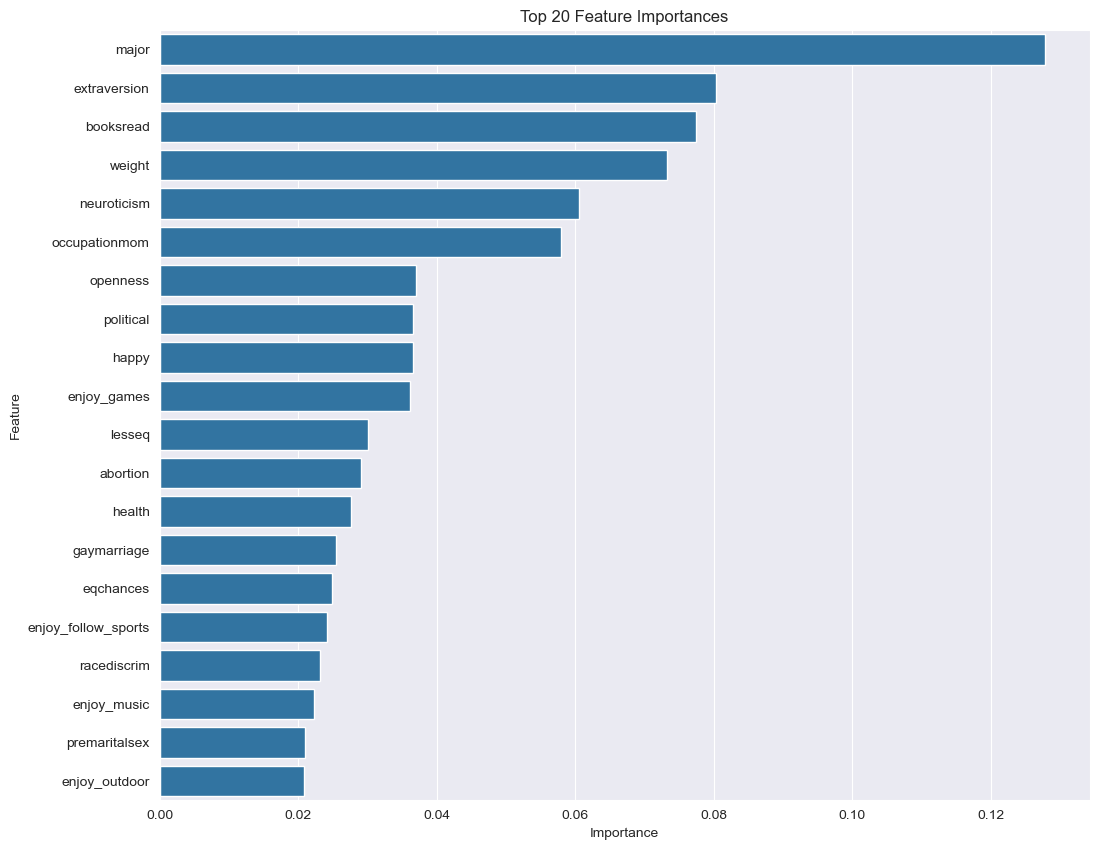

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'features_df' already contains 'Feature' and 'Importance' columns
# Sort the DataFrame by 'Importance' and select the top 20
top_features_df = features_df.sort_values(by='Importance', ascending=False).head(20)

# Plotting feature importances for the top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=top_features_df)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
